2021-1-12

# References:

http://m.mlb.com/glossary/rules

https://www.beyondtheboxscore.com/2009/4/17/841366/understanding-pitch-f-x-graphs

https://blogs.fangraphs.com/the-size-of-the-strike-zone-by-count/

http://www.baseballdatascience.com/game-theory-applications-in-baseball/

https://spiderselite.com/2018/03/25/count-hitting-results/

https://www.lookoutlanding.com/2012/10/29/3561060/the-strike-zone

https://www.baseballprospectus.com/news/article/40891/prospectus-feature-the-universal-strike-zone/

https://baseballcloud.blog/2020/07/09/quantifying-command-part-two-edge-percentage/

In [1]:
#@title Download data
from google_drive_downloader import google_drive_downloader as gdd
gdd.GoogleDriveDownloader.download_file_from_google_drive(
    file_id="11ivfD99GXCN6pOgQyBaBAPImzYaDYqV_", dest_path="./fastballcommand.xlsx", showsize=True,
)

1.2 MiB Done.


# Global functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D, art3d
import matplotlib.animation as animation
plt.style.use('ggplot')
import seaborn as sns
from IPython.display import display, HTML
from tqdm.notebook import tqdm
from PIL import Image
from functools import partial
import scipy
import os,time
variables = locals()

def create_folder(folder):
    if os.path.exists(folder)==0 and folder!="":
        try:
            os.makedirs(folder)  # auto create folder if it doesn't exist
        except:
            print("\n(꒪Д꒪)ノ\tPATH ERROR -- cannot create folder:", folder)

def sigmoid(x):
  return 1/(1 + np.exp(-x))

def mae(a): #mean absolute error
  return np.sqrt(np.sum(np.abs(a))/len(a))
def mse(a): #mean square error
  return np.sum(np.power(a, 2))/len(a)
def rmse(a): #root mean square error
  return np.sqrt(mse(a))

def move_legend(ax, new_loc, **kws): #https://github.com/mwaskom/seaborn/issues/2280
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

def array_to_rgba(a, norm=TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1), cmap=cm.seismic):
  return cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(a)

# Load data

In [3]:
df=pd.read_excel("fastballcommand.xlsx", sheet_name=0)
df["PlateLocHeight"] *= 12 #convert feet to inches
df["PlateLocSide"] *= 12 #convert feet to inches
columns_categorical = ["YearID", "GameID", "PitcherID"]
for col in columns_categorical:
  df[col] = df[col].astype('category')
df

YearID  ... PlateLocSide
0       2018  ...    -6.890461
1       2018  ...     5.809139
2       2018  ...    -6.020461
3       2018  ...     2.512739
4       2018  ...    -7.054861
...      ...  ...          ...
12476   2018  ...     8.783731
12477   2018  ...    -3.273869
12478   2018  ...    -0.751469
12479   2018  ...    -4.826669
12480   2018  ...   -10.273469

[12481 rows x 17 columns]

In [ ]:
df.dtypes

YearID                category
GameID                category
GamePitchSequence        int64
PAofInning               int64
AtBatPitchSequence       int64
Inning                   int64
Balls                    int64
Strikes                  int64
PitcherID             category
PitcherHand             object
BatSide                 object
PitchType               object
Velocity               float64
VerticalBreak          float64
HorizontalBreak        float64
PlateLocHeight         float64
PlateLocSide           float64
dtype: object

# Feature engineering

In [4]:
df["BreakDistance"] = (df["VerticalBreak"]**2 + df["HorizontalBreak"]**2)**0.5  #Euclidean distance of total break (measuring how much the ball has deviated from the initial path)
df["Counts"] = df.apply(lambda x: f"{x.Balls}-{x.Strikes}", axis=1)
df

YearID                                GameID  ...  BreakDistance  Counts
0       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      18.651305     0-0
1       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      18.307565     1-0
2       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      16.715553     1-1
3       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      21.492444     0-0
4       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      20.151967     0-1
...      ...                                   ...  ...            ...     ...
12476   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...      21.240755     0-0
12477   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...      25.926939     1-0
12478   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...      19.023539     2-1
12479   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...      18.070887     1-1
12480   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...      14.069811     0-1

[12481 rows x 19 columns]

# EDA

In [ ]:
df.describe()

GamePitchSequence    PAofInning  ...  PlateLocSide  BreakDistance
count       12481.000000  12481.000000  ...  12474.000000   12474.000000
mean          102.192453      2.649547  ...     -0.809592      18.207133
std            70.691196      1.509402  ...      9.423810       2.147143
min             1.000000      1.000000  ...    -44.292376       7.825139
25%            44.000000      1.000000  ...     -7.296939      16.878201
50%            95.000000      2.000000  ...     -0.886401      18.360122
75%           151.000000      3.000000  ...      5.731124      19.683234
max           480.000000     11.000000  ...     38.276339      27.674714

[8 rows x 12 columns]

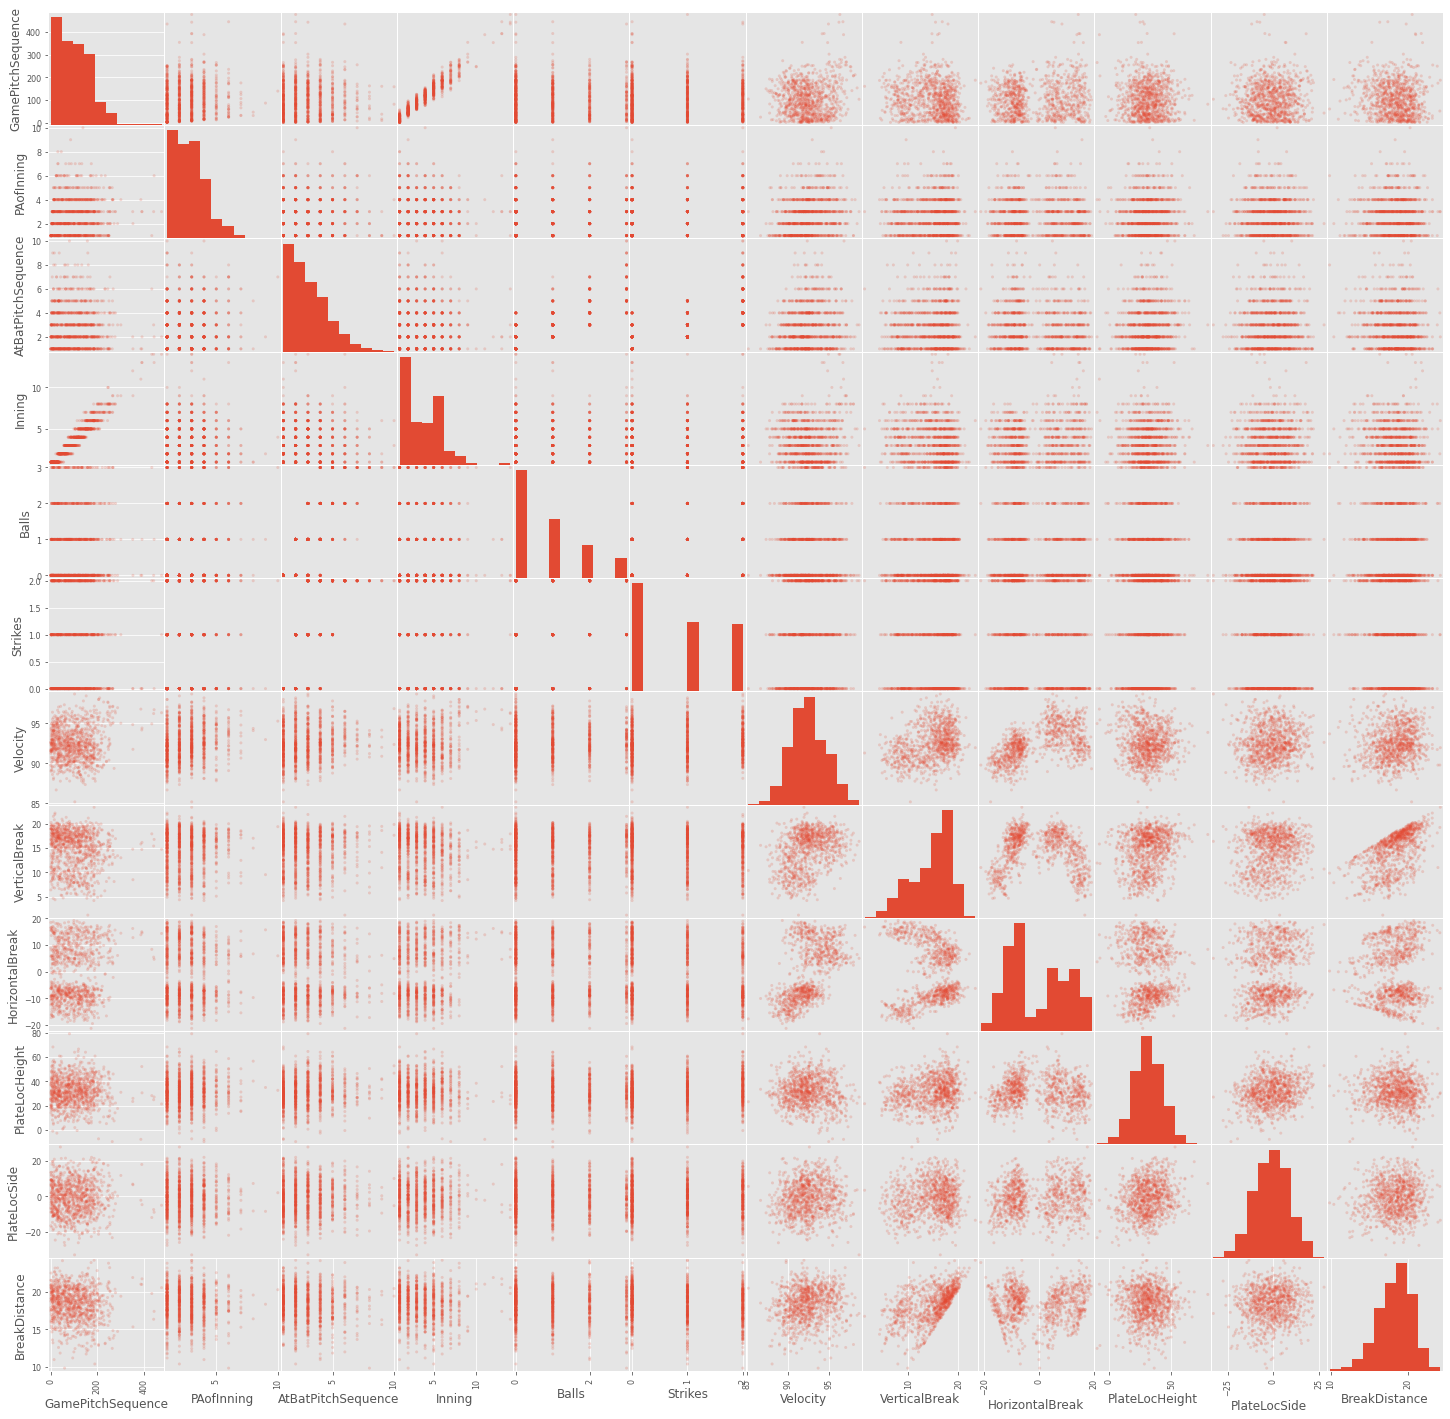

In [ ]:
_ = pd.plotting.scatter_matrix(df.sample(1000), alpha=0.2, figsize=(25,25))

In [ ]:
df.columns

Index(['YearID', 'GameID', 'GamePitchSequence', 'PAofInning',
       'AtBatPitchSequence', 'Inning', 'Balls', 'Strikes', 'PitcherID',
       'PitcherHand', 'BatSide', 'PitchType', 'Velocity', 'VerticalBreak',
       'HorizontalBreak', 'PlateLocHeight', 'PlateLocSide', 'BreakDistance',
       'Counts'],
      dtype='object')

In [ ]:
pd.crosstab(df.PitcherID, [df.PitcherHand, df.BatSide, df.PitchType]).style.background_gradient()

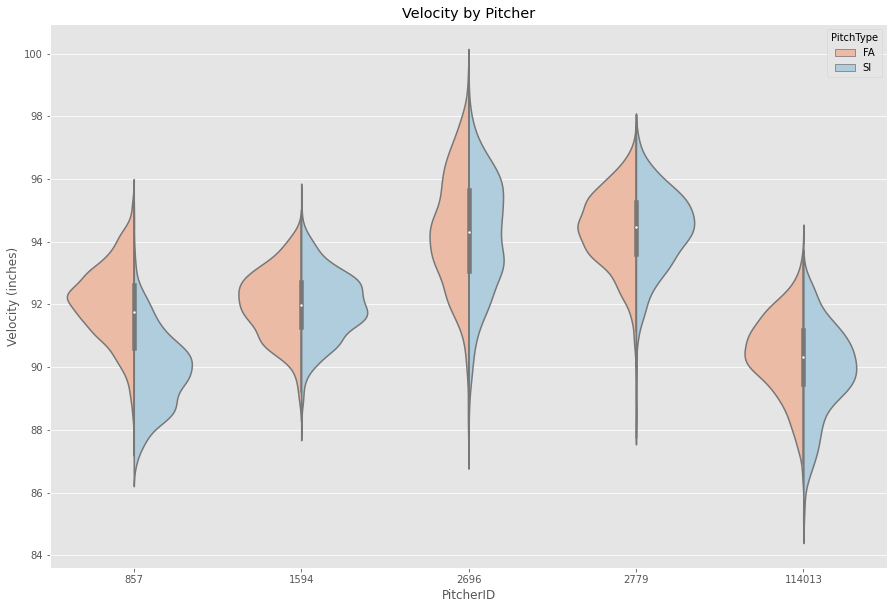

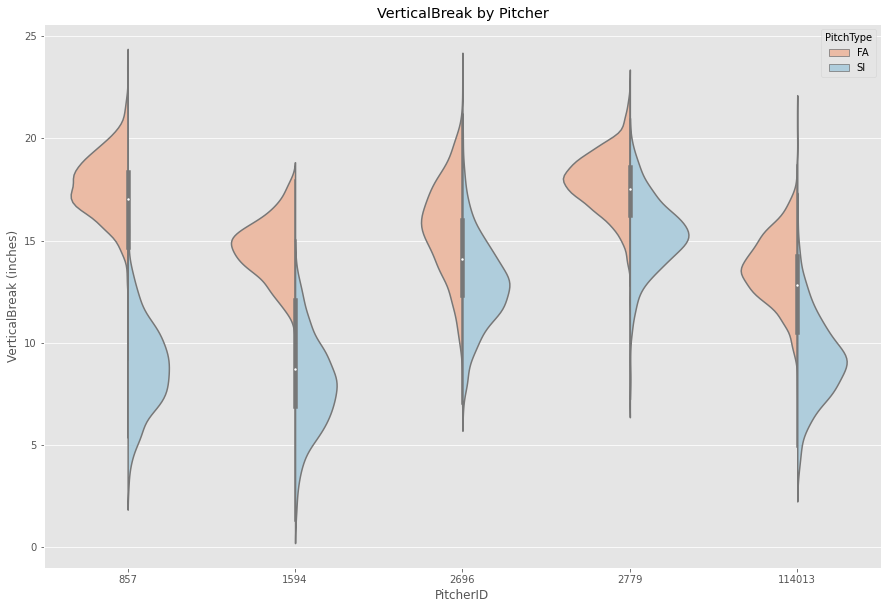

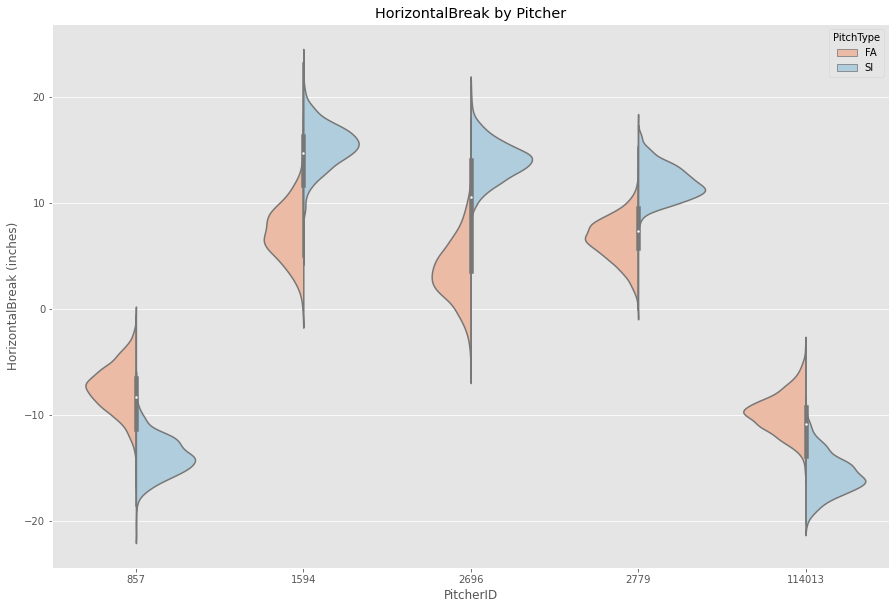

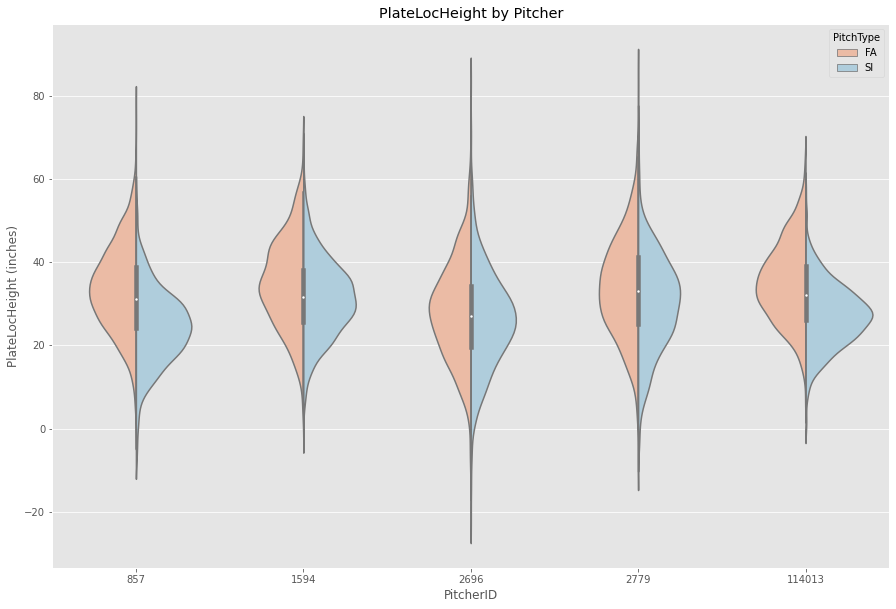

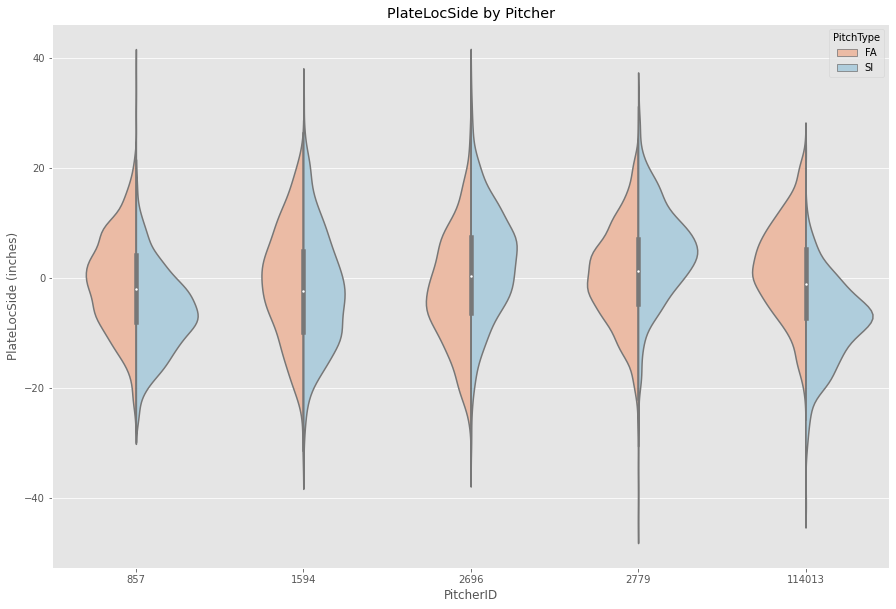

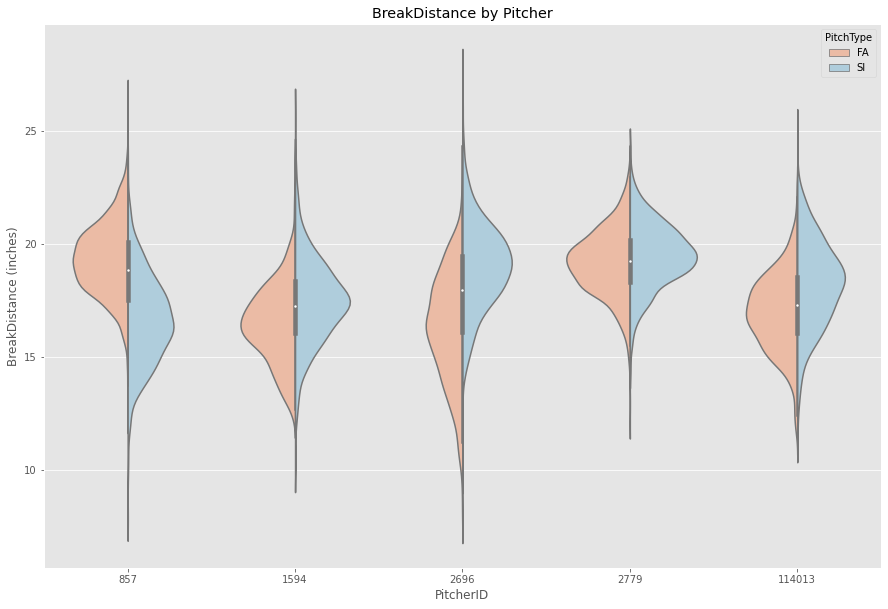

In [ ]:
for var in ['Velocity', 'VerticalBreak','HorizontalBreak', 'PlateLocHeight', 'PlateLocSide', "BreakDistance"]:
  fig, ax = plt.subplots(figsize=(15,10))
  ax= sns.violinplot(ax=ax, data=df, x="PitcherID", y=var, hue="PitchType", split=True, scale_hue=False, palette="RdBu")
  ax.set(ylabel=f"{ax.get_ylabel()} (inches)", title=f"{var} by Pitcher");

In [ ]:
df.PitcherID.value_counts()

857       4528
2696      2246
2779      2233
114013    1947
1594      1527
Name: PitcherID, dtype: int64

In [ ]:
#pair plot by pitcher
var = "PitcherID"
for p in tqdm(df[var].unique()):
  ax = pd.plotting.scatter_matrix(df[df[var]==p].sample(1000), alpha=0.2, figsize=(25,25))
  plt.suptitle(f"{var}: {p}", y=0.9)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
cols = [var, "PitchType", 'Velocity', 'VerticalBreak', 'HorizontalBreak', 'PlateLocHeight', 'PlateLocSide']
for p in tqdm(df[var].unique()):
  g = sns.pairplot(df[df[var]==p][cols].sample(1000), hue="PitchType", diag_kind="hist")
  g.fig.subplots_adjust(top=0.95)
  g.fig.suptitle(f"Ball stats for {var}: {p}", fontsize=16)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for Balls in range(4):
  for Strikes in range(3):
    variables[f"df_{Balls}_{Strikes}"] = df[(df.Balls==Balls) & (df.Strikes==Strikes)]
display(df_3_0)
display(df_0_2)

YearID                                GameID  ...  PlateLocSide  BreakDistance
16      2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      5.941139      20.404721
90      2019  9CCFE8D1-A76E-4488-9958-01D933ABF12C  ...     -7.352758      17.134902
122     2018  564B239E-75E8-4389-9C47-0219712B5AD5  ...     -6.750453      18.397974
167     2018  564B239E-75E8-4389-9C47-0219712B5AD5  ...    -11.197653      18.607029
178     2019  69D50481-2E5A-4723-8B30-021BFA6026D8  ...    -41.142393      15.544716
...      ...                                   ...  ...           ...            ...
12165   2019  94C2F894-4D90-44E4-9474-FAE7419D414C  ...      7.902824      21.985752
12200   2018  300DE3BD-46FC-4B0B-9959-FB22F339F4C3  ...     -2.481013      17.675860
12215   2018  300DE3BD-46FC-4B0B-9959-FB22F339F4C3  ...     -7.324213      16.639704
12218   2018  300DE3BD-46FC-4B0B-9959-FB22F339F4C3  ...     -6.457813      14.453174
12233   2018  300DE3BD-46FC-4B0B-9959-FB22F339F4C3  ...    -17.067013      15.600181

[237 rows x 18 columns]

YearID                                GameID  ...  PlateLocSide  BreakDistance
5       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...     -8.412061      18.453425
8       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      2.139539      18.051082
9       2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      5.169539      17.535189
53      2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...     -1.058461      20.856565
56      2018  DFCBC8CF-E0F5-45EF-B07E-0122EE55B257  ...      9.935939      21.299264
...      ...                                   ...  ...           ...            ...
12408   2020  847B2ED9-E8AF-4067-A4E9-FCB0010A27B1  ...     -5.674395      17.801060
12456   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...     -2.617469      14.590217
12468   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...    -21.113069      19.352823
12470   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...     16.985731      16.926801
12474   2018  B34667E5-C2A0-4ADD-9FA5-FFE8027FE335  ...     -3.151469      15.549680

[725 rows x 18 columns]

In [ ]:
display(df_3_0.describe())
display(df_0_2.describe())

GamePitchSequence  PAofInning  ...  PlateLocSide  BreakDistance
count         237.000000  237.000000  ...    237.000000     237.000000
mean          109.291139    2.780591  ...     -0.668505      17.828810
std            75.873806    1.589946  ...      9.451851       2.259456
min             4.000000    1.000000  ...    -41.142393      11.227869
25%            52.000000    2.000000  ...     -6.751658      16.364160
50%           101.000000    3.000000  ...     -0.799469      18.077843
75%           154.000000    4.000000  ...      5.169364      19.657487
max           470.000000   10.000000  ...     32.898999      23.728679

[8 rows x 12 columns]

GamePitchSequence  PAofInning  ...  PlateLocSide  BreakDistance
count         725.000000  725.000000  ...    724.000000     724.000000
mean          103.244138    2.688276  ...     -1.180058      17.920492
std            67.671287    1.514000  ...      9.676788       2.133179
min             3.000000    1.000000  ...    -32.988562       7.943177
25%            48.000000    1.000000  ...     -7.397160      16.569877
50%           100.000000    3.000000  ...     -1.084647      17.956361
75%           150.000000    3.000000  ...      5.375415      19.388981
max           478.000000   11.000000  ...     36.748531      23.893734

[8 rows x 12 columns]

## Strike Zone visualization

Assuming universal strike zone: 19.94" wide, 18.29" bottomm, 44.08" top

<img src="https://www.baseballprospectus.com/wp-content/uploads/2018/06/universal2-768x818.png"/>

Source: https://www.baseballprospectus.com/news/article/40891/prospectus-feature-the-universal-strike-zone/



In [5]:
strike_zone = pd.Series({
    "name": "universal strike zone",
    "top": 44.08,
    "bottom": 18.29,
    "left": -19.94/2,
    "right": 19.94/2,
    "height": 25.79,
    "width": 19.94,
    "x": 0,
    "y": 18.29+25.79/2,
})
print(strike_zone)

def plot_pitch_location(df, figsize=(12,15), col="PitchType", title="Pitch location scatter plot"):
  df_original = df.copy()
  categories = sorted(df_original[col].unique())
  n_categories = len(categories)
  fig, axes = plt.subplots(nrows=1, ncols=n_categories, figsize=(figsize[0]*n_categories, figsize[1]))
  fig.subplots_adjust(wspace=0.1)
  scale_size = lambda x: x*2
  for i, var in enumerate(categories):
    df = df_original[df_original[col]==var]
    p = axes[i].scatter(
        x=df["PlateLocSide"], y=df["PlateLocHeight"], 
        s=df["BreakDistance"].apply(scale_size), 
        c=df["Velocity"], cmap="plasma",
        alpha=0.75, 
        marker=r'$\bigcirc$', #LaTeX symbols: https://artofproblemsolving.com/wiki/index.php/LaTeX:Symbols
        )
    axes[i].set_xlabel("PlateLocSide (inches)"); axes[i].set_ylabel("PlateLocHeight (inches)");
    axes[i].set_title(f"{col}: {var}");
    cbar = fig.colorbar(p, ax=axes[i])
    cbar.ax.set_ylabel("Velocity (mph)", rotation=90)
    for area in [5,10,15,20,25]:
        axes[i].scatter([], [], c="k", marker=r'$\bigcirc$', alpha=1, s=scale_size(area), label=str(area))
    axes[i].legend(scatterpoints=1, frameon=True, labelspacing=1.3, title="BreakDistance (inches)", facecolor="white", framealpha=0.5);
    axes[i].axis('equal')
    rect = patches.Rectangle((strike_zone.left,strike_zone.bottom),strike_zone.width,strike_zone.height,linewidth=2,edgecolor='red',facecolor='none')
    axes[i].add_patch(rect);
    axes[i].text(0.01, 0.02, "* Red box: universal strike zone", horizontalalignment='left', verticalalignment='top', transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))
  fig.suptitle(title, fontsize=28, y=0.93)

def plot_pitch_location_kde(df, figsize=(12,15), nbins=100, col="PitchType", title="Pitch location kernel density estimation"):
  from scipy.stats import kde
  # from sklearn.neighbors import KernelDensity
  df_original = df.copy()
  categories = sorted(df_original[col].unique())
  n_categories = len(categories)
  fig, axes = plt.subplots(nrows=1, ncols=n_categories, figsize=(figsize[0]*n_categories, figsize[1]))
  fig.subplots_adjust(wspace=0.1)
  for i, var in enumerate(categories):
    df = df_original[df_original[col]==var]
    df_xy = df[["PlateLocSide","PlateLocHeight"]].dropna().values
    x,y = df_xy.T
    k = kde.gaussian_kde(df_xy.T)
    # k = lambda input: KernelDensity(kernel='exponential').fit(df_xy).score_samples(input.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    p = axes[i].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="plasma")
    axes[i].contour(xi, yi, zi.reshape(xi.shape) )
    axes[i].set_xlabel("PlateLocSide (inches)"); axes[i].set_ylabel("PlateLocHeight (inches)");
    axes[i].set_title(f"{col}: {var}");

    cbar = fig.colorbar(p, ax=axes[i])
    cbar.ax.set_ylabel("Probability density", rotation=90)
    axes[i].axis('equal')
    rect = patches.Rectangle((strike_zone.left,strike_zone.bottom),strike_zone.width,strike_zone.height,linewidth=2,edgecolor='red',facecolor='none')
    axes[i].add_patch(rect);
    axes[i].text(0.01, 0.02, "* Red box: universal strike zone", horizontalalignment='left', verticalalignment='top', transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))
  fig.suptitle(title, fontsize=28, y=0.93)

name      universal strike zone
top                       44.08
bottom                    18.29
left                      -9.97
right                      9.97
height                    25.79
width                     19.94
x                             0
y                        31.185
dtype: object


In [ ]:
var = "PitcherID"
col = "PitchType"
for p in tqdm(df[var].unique()):
  plot_pitch_location(df[df[var]==p], col=col, title=f"Pitch location vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "BatSide"
for p in tqdm(df[var].unique()):
  plot_pitch_location(df[df[var]==p], col=col, title=f"Pitch location vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "Counts"
for p in tqdm(df[var].unique()):
  plot_pitch_location(df[df[var]==p], col=col, title=f"Pitch location vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "PitchType"
for p in tqdm(df[var].unique()):
  plot_pitch_location_kde(df[df[var]==p], col=col, title=f"Pitch location estimation vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "BatSide"
for p in tqdm(df[var].unique()):
  plot_pitch_location_kde(df[df[var]==p], col=col, title=f"Pitch location estimation vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "BatSide"
for p in tqdm(df[var].unique()):
  plot_pitch_location_kde(df[(df[var]==p)&(df.PitchType=="SI")], col=col, title=f"Two-seam pitch location estimation vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "BatSide"
for p in tqdm(df[var].unique()):
  plot_pitch_location_kde(df[(df[var]==p)&(df.PitchType=="FA")], col=col, title=f"Four-seam pitch location estimation vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "Counts"
for p in tqdm(df[var].unique()):
  plot_pitch_location_kde(df[(df[var]==p)&(df.PitchType=="SI")], col=col, title=f"Two-seam pitch location estimation vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
var = "PitcherID"
col = "Counts"
for p in tqdm(df[var].unique()):
  plot_pitch_location_kde(df[(df[var]==p)&(df.PitchType=="FA")], col=col, title=f"Four-seam pitch location estimation vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

# Pitch Command performance measurement

Logic: measure the distance of the pitch locations to the edges of the strike zone. The smaller the average distance, the better.

## Custom Pitch Score

To determine how good each pitch is

In [6]:
def calculate_pitch_score(PlateLocHeight, PlateLocSide, normalize=False, normalize_rescale=0.1): #metric for measuring how each pitch location deviates from the strike zone edges. The closer the number is to 0, the better.
  if pd.isnull(PlateLocHeight) or pd.isnull(pd.isnull(PlateLocSide)): return #if the data are missing, don't calculate the score
  distance_vertical = min([abs(PlateLocHeight-strike_zone.top), abs(PlateLocHeight-strike_zone.bottom)]) #distance from the pitch location to the nearest horizontal strike zone edge (top or bottom edge)
  distance_horizontal = min([abs(PlateLocSide-strike_zone.left), abs(PlateLocSide-strike_zone.right)]) #distance from the pitch location to the nearest vertical strike zone edge (left or right edge)
  distance_edge = scipy.stats.hmean([distance_vertical, distance_horizontal]) #edge distance is calculated by the harmonic mean of the horizontal and vertical distances to the edges (whichever edge closest to the ball will have the largest weight)
  sign = 1 #score inside the strike zone is positive by default
  if (not strike_zone.bottom <= PlateLocHeight <= strike_zone.top) or (not strike_zone.left <= PlateLocSide <= strike_zone.right): #if the pitch location is outside the strike zone, let the score decrease evenly with the shape of the strike zone box
    sign = -1 #if the pitch location is outside the strike zone, let the pitch score be negative (to differentiate it from pitch locations inside the strike zone)
    if strike_zone.left <= PlateLocSide <= strike_zone.right: distance_edge = distance_vertical #distance to the top or the bottom edge of the strike zone
    elif strike_zone.bottom <= PlateLocHeight <= strike_zone.top: distance_edge = distance_horizontal #distance to the left or the right edge of the strike zone
    else: distance_edge = max(distance_vertical, distance_horizontal) #distance in the corner directions is measured by distance to the second nearest edge of the strike zone
  distance_edge = distance_edge*sign #score inside: positive; score outside: negative; score on the edge: 0
  if normalize: #rescale the score to between -1 and 1
    distance_edge *= normalize_rescale #down-scale it little bit so the score doesn't decrease so fast from the edge
    if distance_edge >= 0: #inside the zone
      max_score = scipy.stats.hmean([strike_zone.height*normalize_rescale/2, strike_zone.width*normalize_rescale/2]) #center of the strike zone is the highest score, which needs to be rescaled to 1
      distance_edge = scipy.special.logit((distance_edge/max_score/2+0.5))/2*max_score #logit(x)=ln(x/(1-x)), with slope=4 at x=0.5; this transformation ensures the output is inf at x=max_score, 0 at x=0, and slope is 1 at x=0
      distance_edge = np.tanh(distance_edge) #tanh(x)=(exp(2*x)-1)/(exp(2*x)+1), with slope=0 at x=0
    else: distance_edge = (sigmoid(distance_edge*2)-0.5)*2 #sigmoid(x)=1/(1+exp(-x)), with slope = 1/4 at x=0; this transformation ensures the output is -1 at x=-inf, 0 at x=0, and slope is 1 at x=0
  return distance_edge

df["pitch_score"] = df.apply(lambda x: calculate_pitch_score(PlateLocHeight=x.PlateLocHeight, PlateLocSide=x.PlateLocSide, normalize=False), axis=1)
df["pitch_score_normalized"] = df.apply(lambda x: calculate_pitch_score(PlateLocHeight=x.PlateLocHeight, PlateLocSide=x.PlateLocSide, normalize=True), axis=1)
df

YearID  ... pitch_score_normalized
0       2018  ...               0.301862
1       2018  ...               0.384360
2       2018  ...               0.269839
3       2018  ...               0.789329
4       2018  ...               0.244006
...      ...  ...                    ...
12476   2018  ...              -0.743924
12477   2018  ...              -0.131050
12478   2018  ...               0.293413
12479   2018  ...               0.699239
12480   2018  ...              -0.030338

[12481 rows x 21 columns]

### Theoretical Pitch Score distribution by pitch location

To see how this metric behaves for all possible scenarios

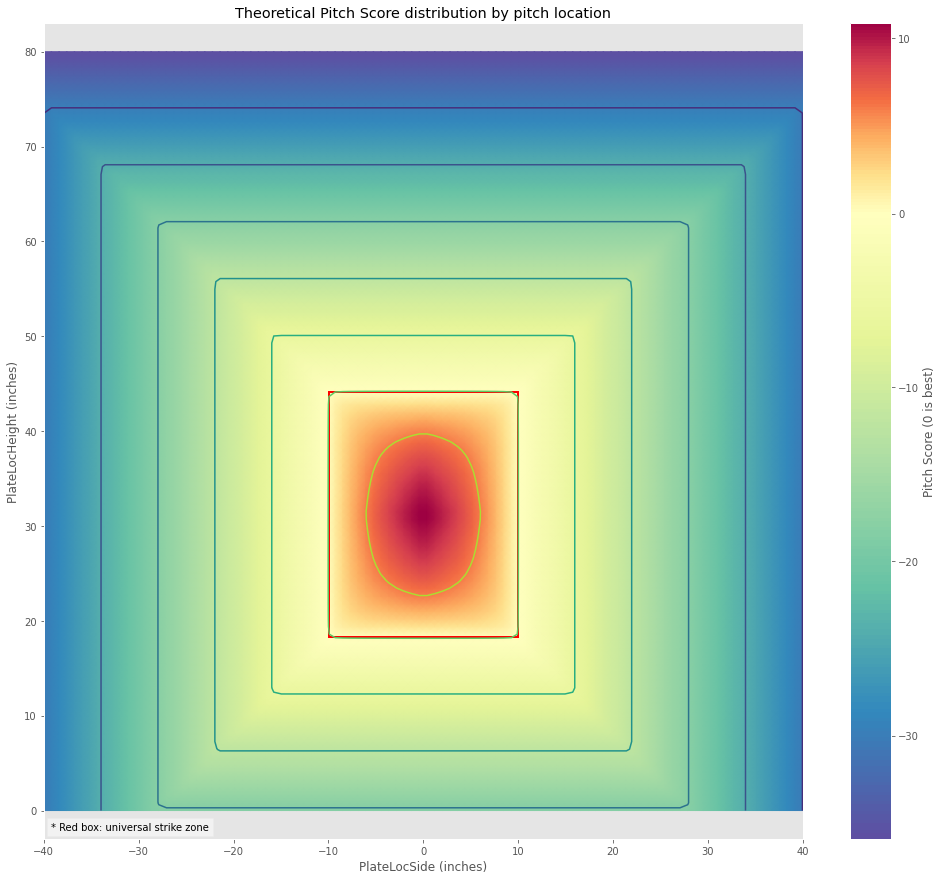

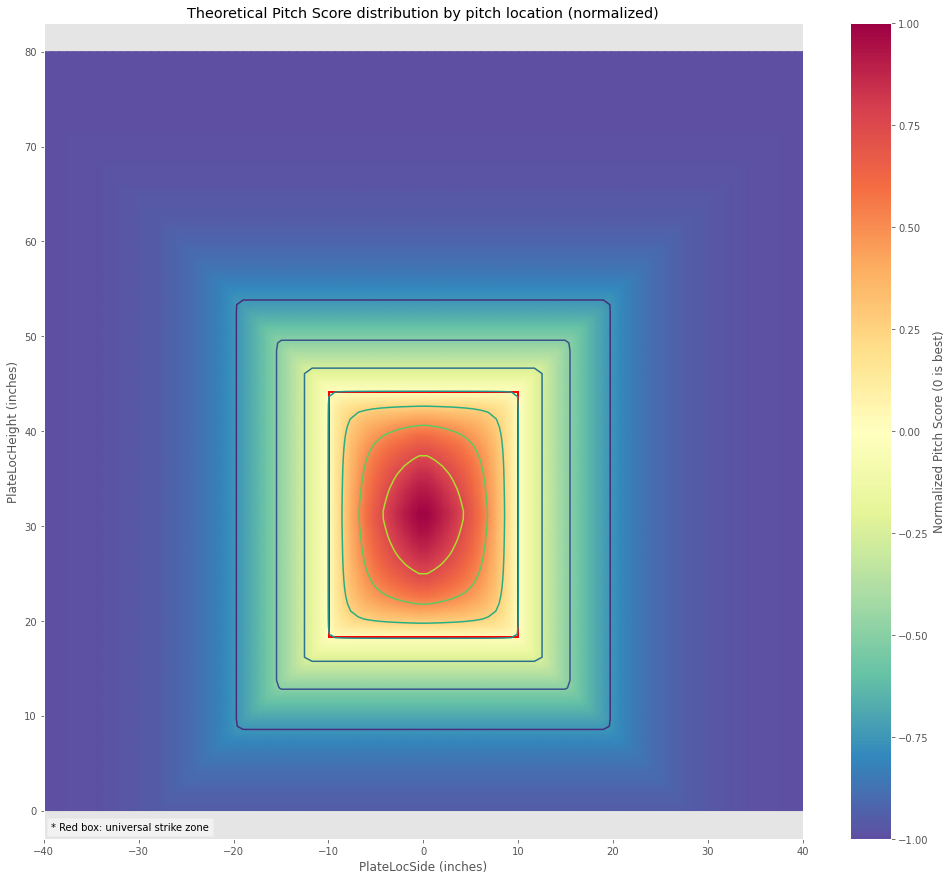

In [ ]:
def simulate_pitch_score_distribution(scoring_function=calculate_pitch_score, x_range=(-40,40), y_range=(0,80), figsize=(17,15), nbins=100, col="PitchType", title="Theoretical Pitch Score distribution by pitch location", normalize=1):
  x_range = np.array(x_range); y_range = np.array(y_range)
  from scipy.stats import kde
  fig, ax = plt.subplots(figsize=figsize)
  scale_size = lambda x: x*2
  xi, yi = np.mgrid[x_range.min():x_range.max():nbins*1j, y_range.min():y_range.max():nbins*1j]
  zi = np.vectorize(partial(calculate_pitch_score, normalize=normalize))(yi.flatten(), xi.flatten())
  vmin, vmax = None, None
  if normalize: vmin, vmax = -1, 1
  p = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="Spectral_r", norm=TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax))
  ax.contour(xi, yi, zi.reshape(xi.shape) )
  ax.set_xlabel("PlateLocSide (inches)"); ax.set_ylabel("PlateLocHeight (inches)");
  ax.set_title(title);
  cbar = fig.colorbar(p, ax=ax)
  cbar.ax.set_ylabel("Pitch Score (0 is best)", rotation=90)
  if normalize: cbar.ax.set_ylabel("Normalized Pitch Score (0 is best)", rotation=90)
  ax.axis('equal')
  rect = patches.Rectangle((strike_zone.left,strike_zone.bottom),strike_zone.width,strike_zone.height,linewidth=2,edgecolor='red',facecolor='none')
  ax.add_patch(rect);
  ax.text(0.01, 0.02, "* Red box: universal strike zone", horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

simulate_pitch_score_distribution(normalize=False, title="Theoretical Pitch Score distribution by pitch location")
simulate_pitch_score_distribution(normalize=True, title="Theoretical Pitch Score distribution by pitch location (normalized)")

In [ ]:
calculate_pitch_score(strike_zone.top, strike_zone.right-2, normalize=True)

0.0

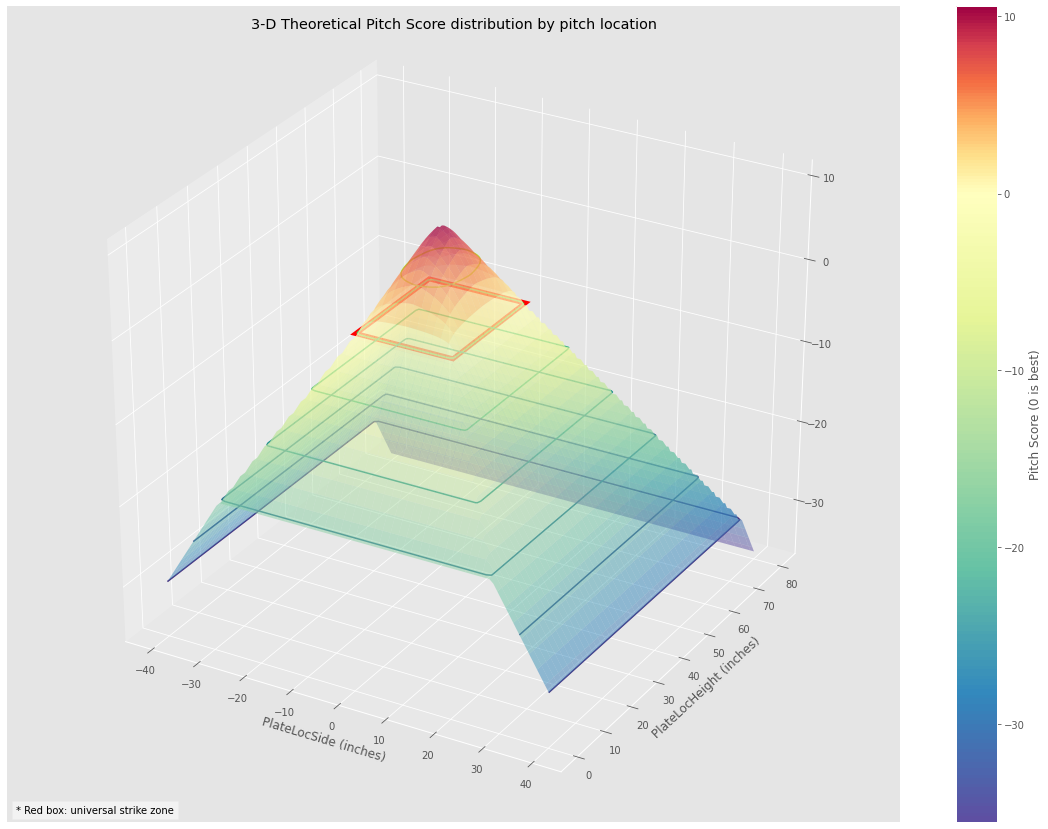

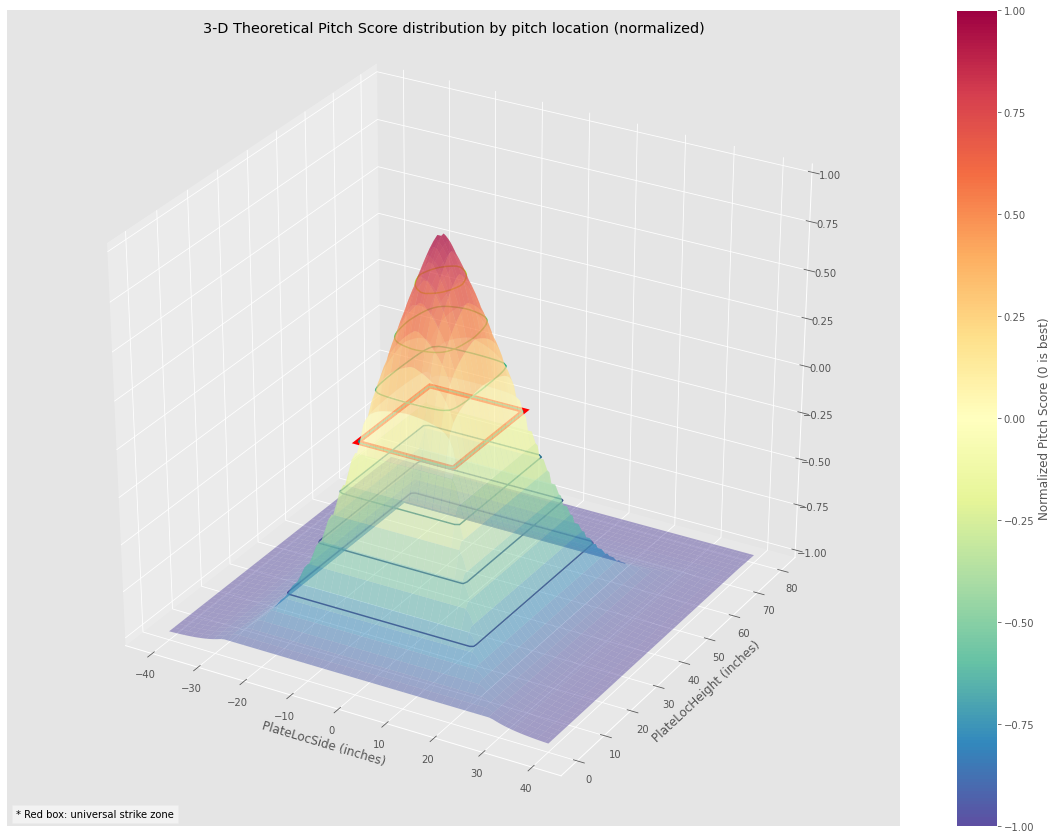

In [ ]:
def simulate_pitch_score_distribution_3d(scoring_function=calculate_pitch_score, x_range=(-40,40), y_range=(0,80), figsize=(20,15), nbins=100, col="PitchType", title="Theoretical Pitch Score distribution by pitch location", normalize=1, animation_path=None):
  x_range = np.array(x_range); y_range = np.array(y_range)
  from scipy.stats import kde
  fig = plt.figure(figsize=figsize)
  ax = fig.gca(projection='3d')
  scale_size = lambda x: x*2
  xi, yi = np.mgrid[x_range.min():x_range.max():nbins*1j, y_range.min():y_range.max():nbins*1j]
  zi = np.vectorize(partial(calculate_pitch_score, normalize=normalize))(yi.flatten(), xi.flatten())
  vmin, vmax = None, None
  if normalize: vmin, vmax = -1, 1
  p = ax.plot_surface(xi, yi, zi.reshape(xi.shape), cmap="Spectral_r", norm=TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax), linewidth=0, alpha=0.5, antialiased=True)
  ax.contour(xi, yi, zi.reshape(xi.shape))
  ax.set_xlabel("PlateLocSide (inches)"); ax.set_ylabel("PlateLocHeight (inches)");
  ax.set_title(title, y=1.05);
  cbar = fig.colorbar(p, ax=ax)
  cbar.set_alpha(1); cbar.draw_all()
  cbar.ax.set_ylabel("Pitch Score (0 is best)", rotation=90)
  if normalize: 
    cbar.ax.set_ylabel("Normalized Pitch Score (0 is best)", rotation=90)
    ax.set_zlim(-1, 1)
  rect = patches.Rectangle((strike_zone.left,strike_zone.bottom),strike_zone.width,strike_zone.height,linewidth=5,edgecolor='red',facecolor='none')
  ax.add_patch(rect);
  art3d.pathpatch_2d_to_3d(rect, z=0, zdir="z")
  ax.text2D(0.01, 0.02, "* Red box: universal strike zone", horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
  if animation_path:
    create_folder(animation_path)
    for angle in tqdm(range(0, 360)):
      ax.view_init(elev=30, azim=angle) #https://stackoverflow.com/questions/18344934/animate-a-rotating-3d-graph-in-matplotlib
      fig.tight_layout()
      fig.savefig(os.path.join(animation_path, f"{title} - {angle}.png"))

simulate_pitch_score_distribution_3d(normalize=False, title="3-D Theoretical Pitch Score distribution by pitch location")
simulate_pitch_score_distribution_3d(normalize=True, title="3-D Theoretical Pitch Score distribution by pitch location (normalized)")

Discussion: 

Both the raw Pitch Score and the Normalized Pitch Score seem useful. The raw Pitch Score relects the absolute distance (in inches) between the pitch location and the edges of the strike zone, whereas the Normalized Pitch Score can be a more straightforward and intuitive metric (between -1 and 1) for comparing the goodness of the pitch. 

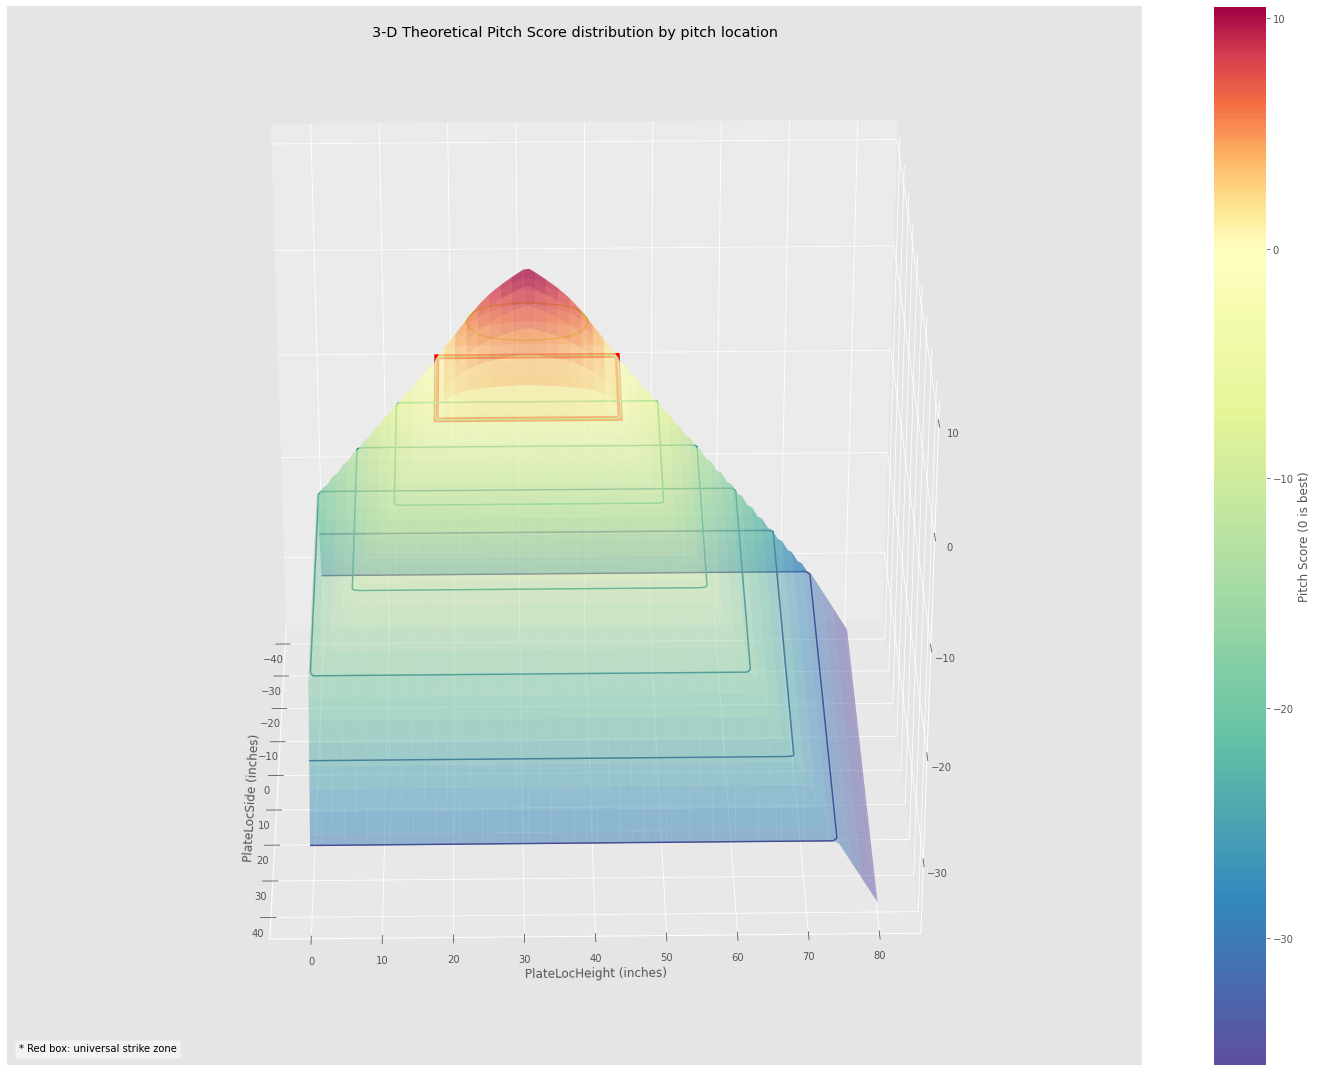

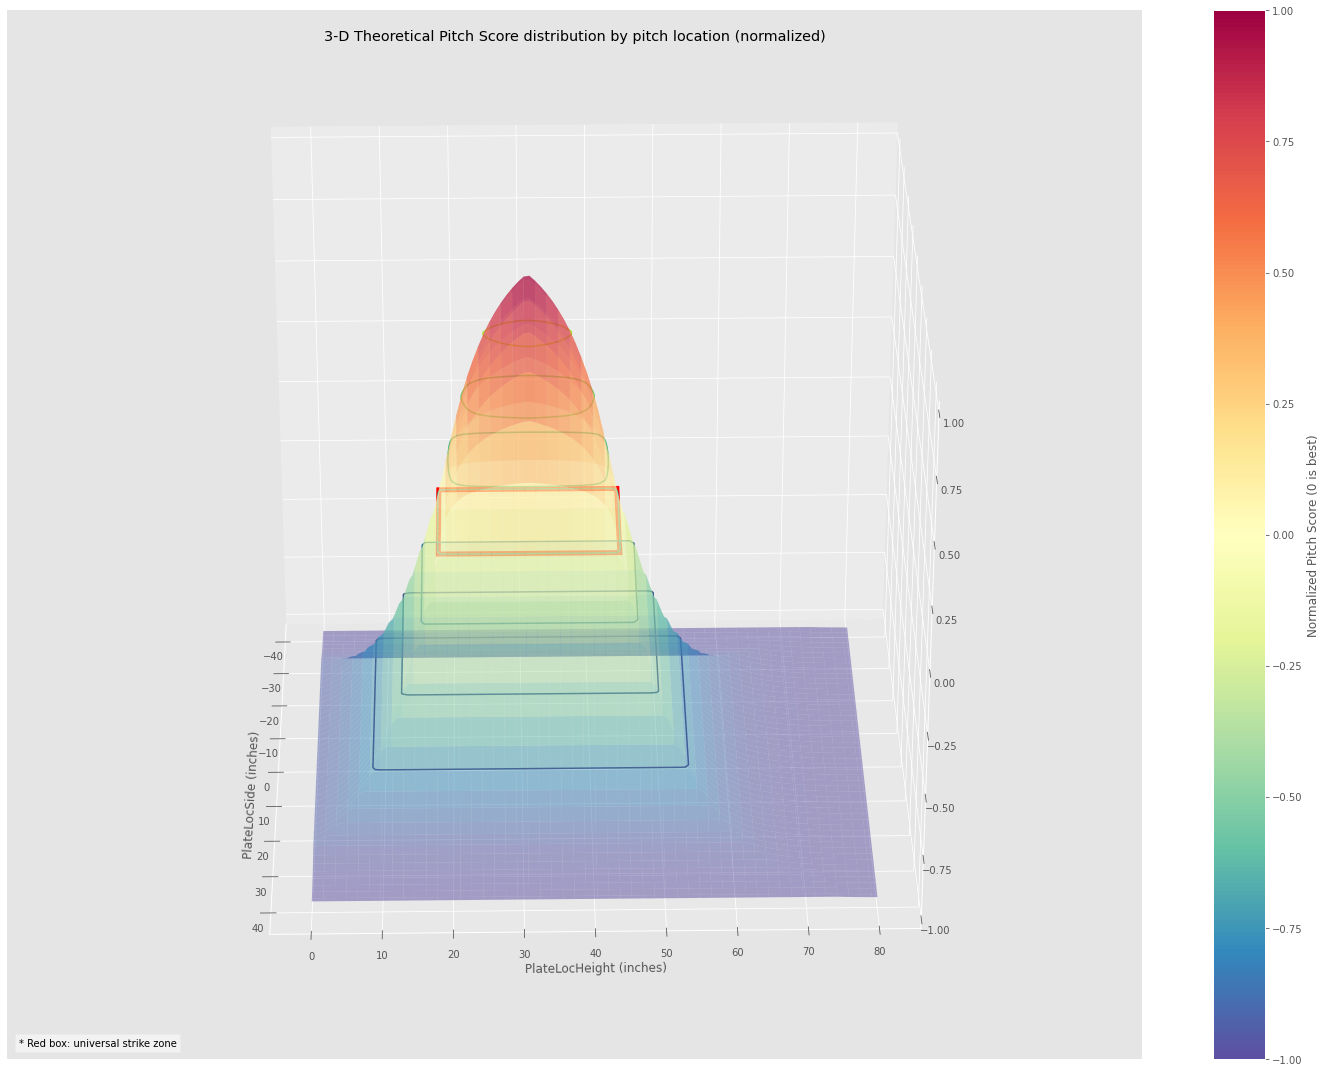

In [ ]:
#render animations
simulate_pitch_score_distribution_3d(normalize=False, title="3-D Theoretical Pitch Score distribution by pitch location", animation_path="anim")
simulate_pitch_score_distribution_3d(normalize=True, title="3-D Theoretical Pitch Score distribution by pitch location (normalized)", animation_path="anim")

In [ ]:
%%bash
ffmpeg -r 30 -i "anim/3-D Theoretical Pitch Score distribution by pitch location - %d.png" -c:v libx264 -vf fps=25 -pix_fmt yuv420p "3-D Theoretical Pitch Score distribution by pitch location.mp4"

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
%%bash
ffmpeg -r 30 -i "anim/3-D Theoretical Pitch Score distribution by pitch location (normalized) - %d.png" -c:v libx264 -vf fps=25 -pix_fmt yuv420p "3-D Theoretical Pitch Score distribution by pitch location (normalized).mp4"

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

### Real-world Pitch Score histogram

In [ ]:
def plot_pitch_score_histogram(df, figsize=(20,15), col="PitchType", title="Normalized Pitch Score histogram"):
  fig, ax = plt.subplots(figsize=figsize)
  g = sns.histplot(df, x="pitch_score_normalized", hue=col, kde=True, alpha=0.5, ax=ax);
  move_legend(g, "upper left")
  ax.axvline(x=0, color='g', alpha=0.6, linestyle='--', lw=2, label="Best score (on the edge)")
  fig.legend(bbox_to_anchor=(0, 0, 0.8, 0.79), facecolor="white", framealpha=0.5)
  g.set_xlabel("Normalized Pitch Score")
  g.set_title(title, fontsize=16)
  g.annotate(" → Inside Strike Zone", xy=(0, g.get_ybound()[1]*0.99), xytext=(0, g.get_ybound()[1]*0.99), horizontalalignment="left", verticalalignment="top", size=16, alpha=0.6)
  g.annotate("Outside Strike Zone ← ", xy=(0, g.get_ybound()[1]*0.99), xytext=(0, g.get_ybound()[1]*0.99), horizontalalignment="right", verticalalignment="top", size=16, alpha=0.6)
  ax2 = ax.twinx()
  ax2.grid(False)
  ax2.set_ylim(g.get_ylim())
  ax2.set_yticklabels(np.round(g.get_yticks()/len(df),2))
  ax2.set_ylabel('Probability')

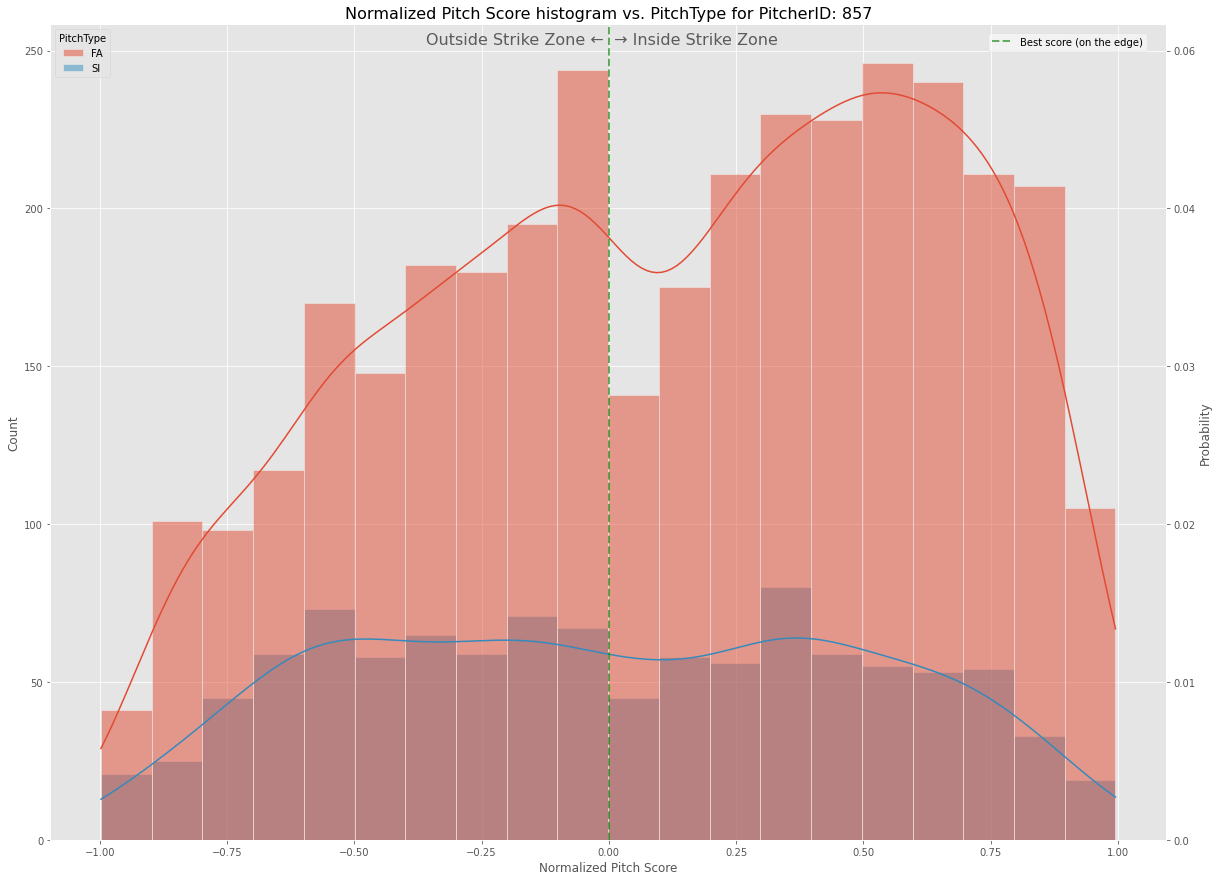

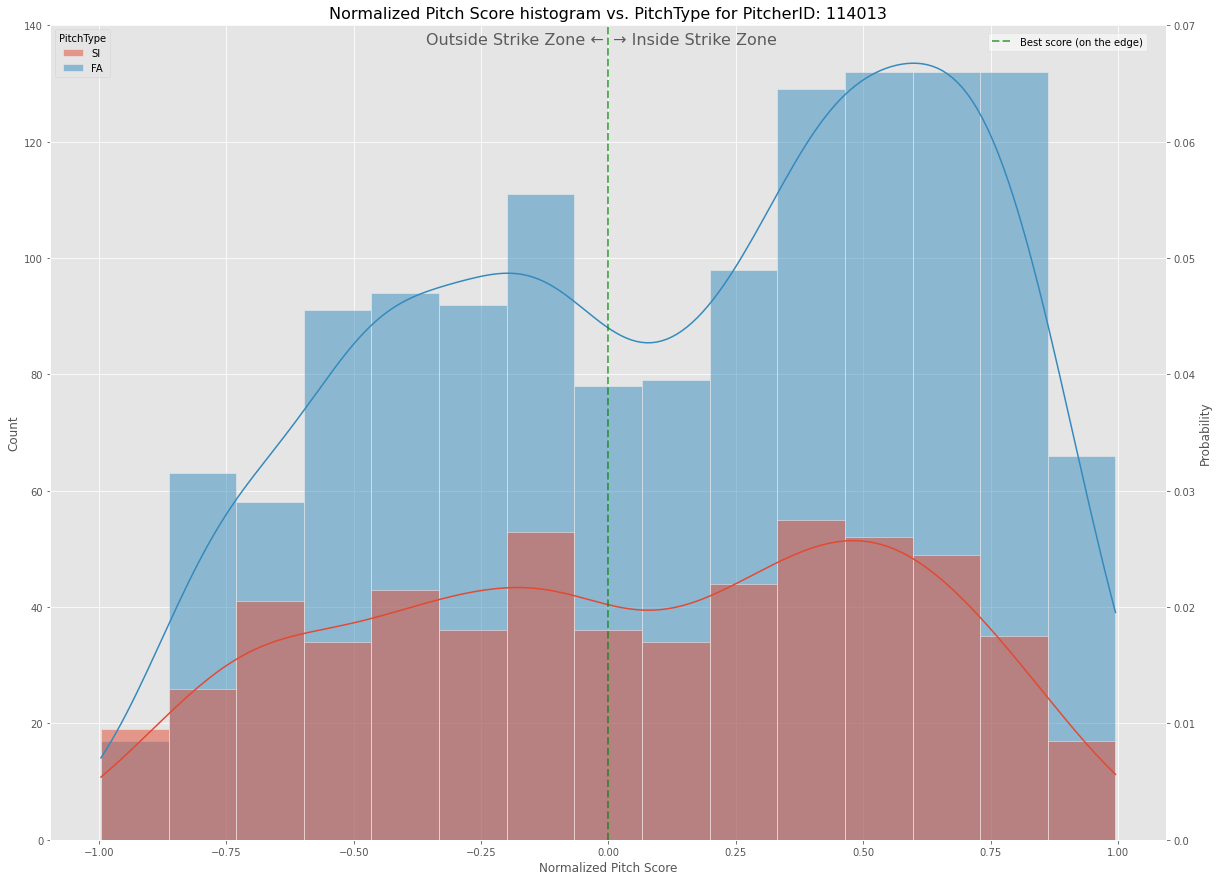

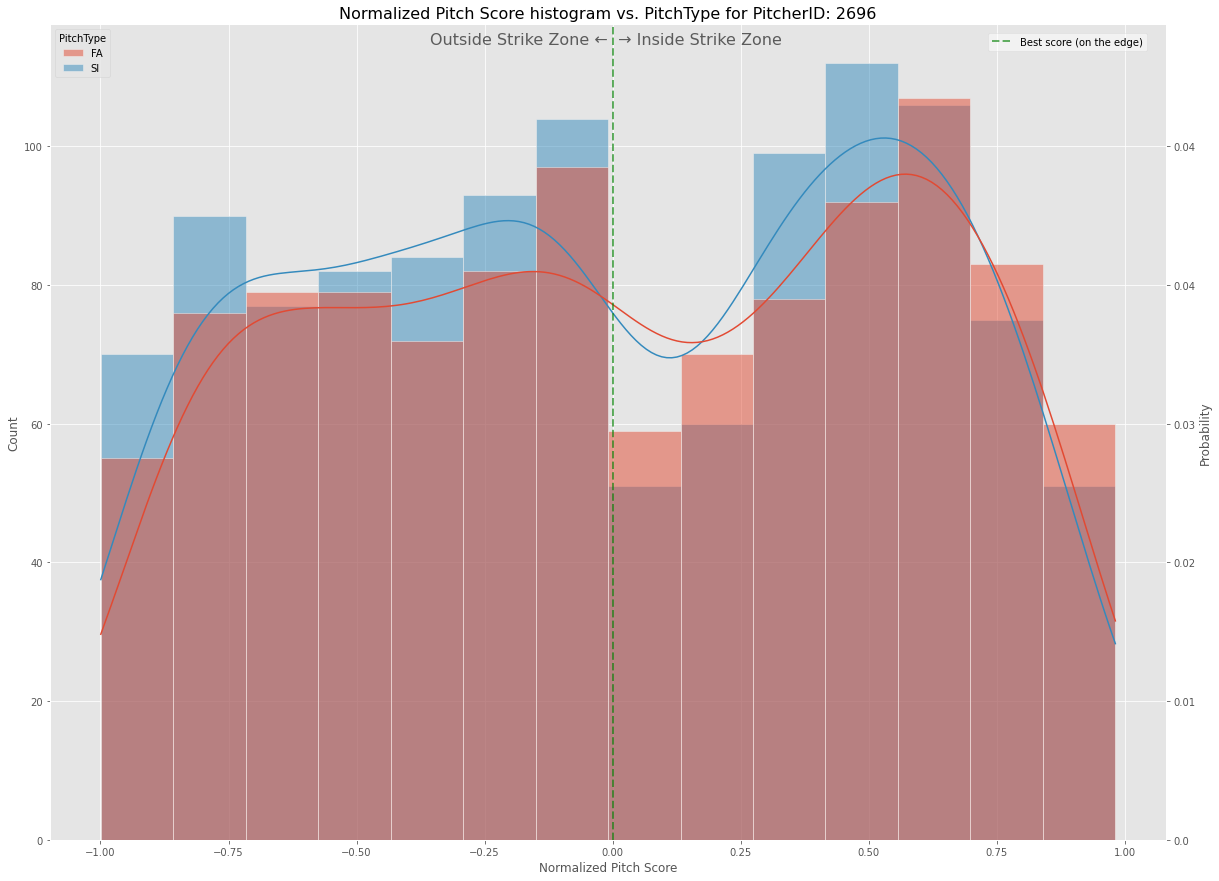

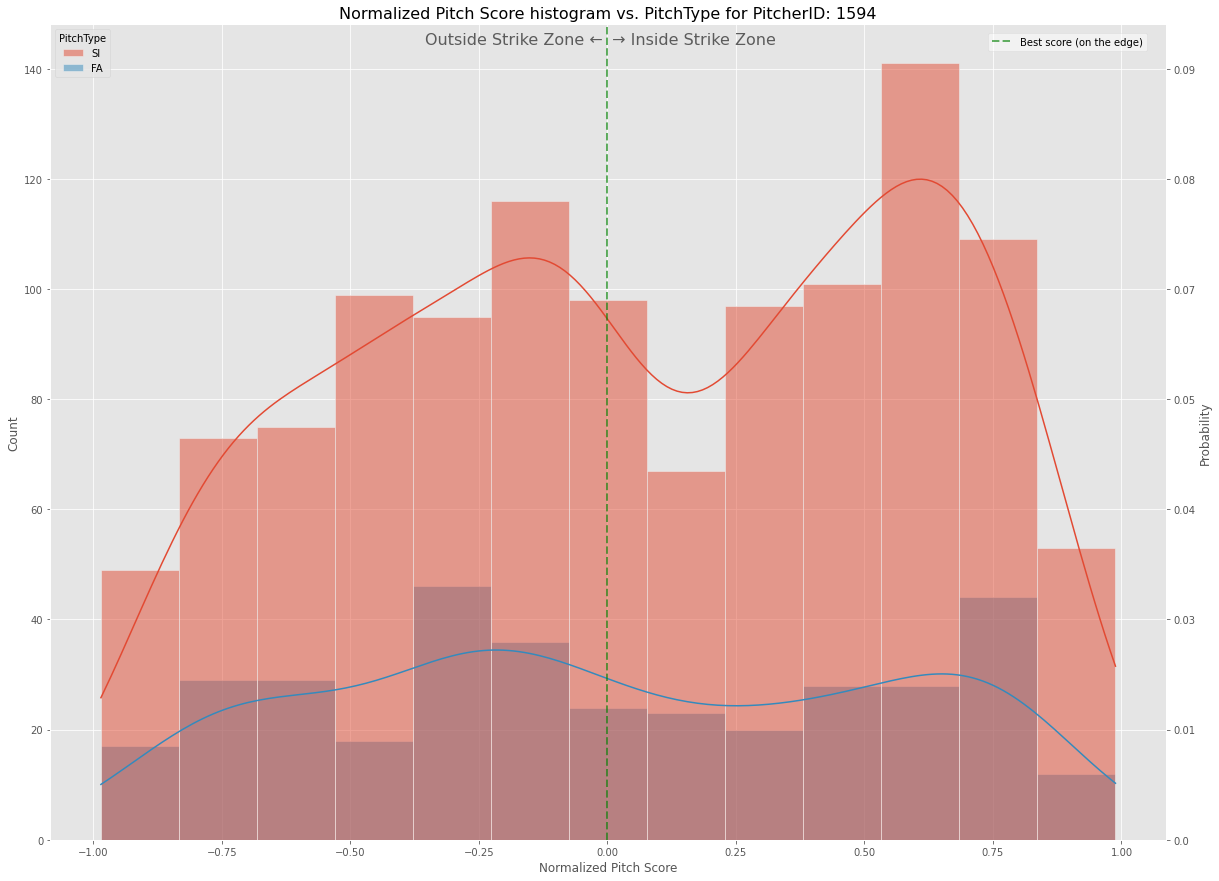

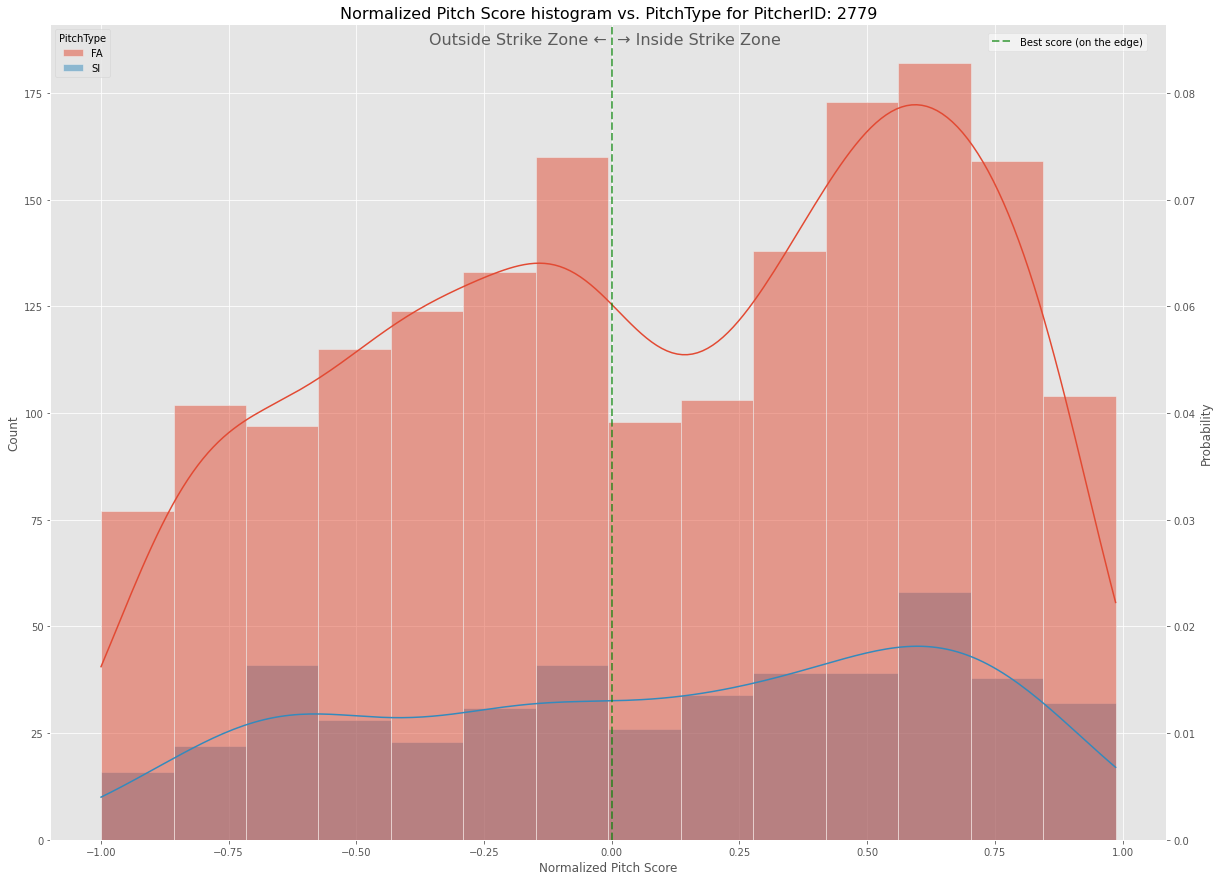

In [ ]:
var = "PitcherID"
col="PitchType"
for p in tqdm(df[var].unique()):
  plot_pitch_score_histogram(df[df[var]==p], col=col, title=f"Normalized Pitch Score histogram vs. {col} for {var}: {p}")

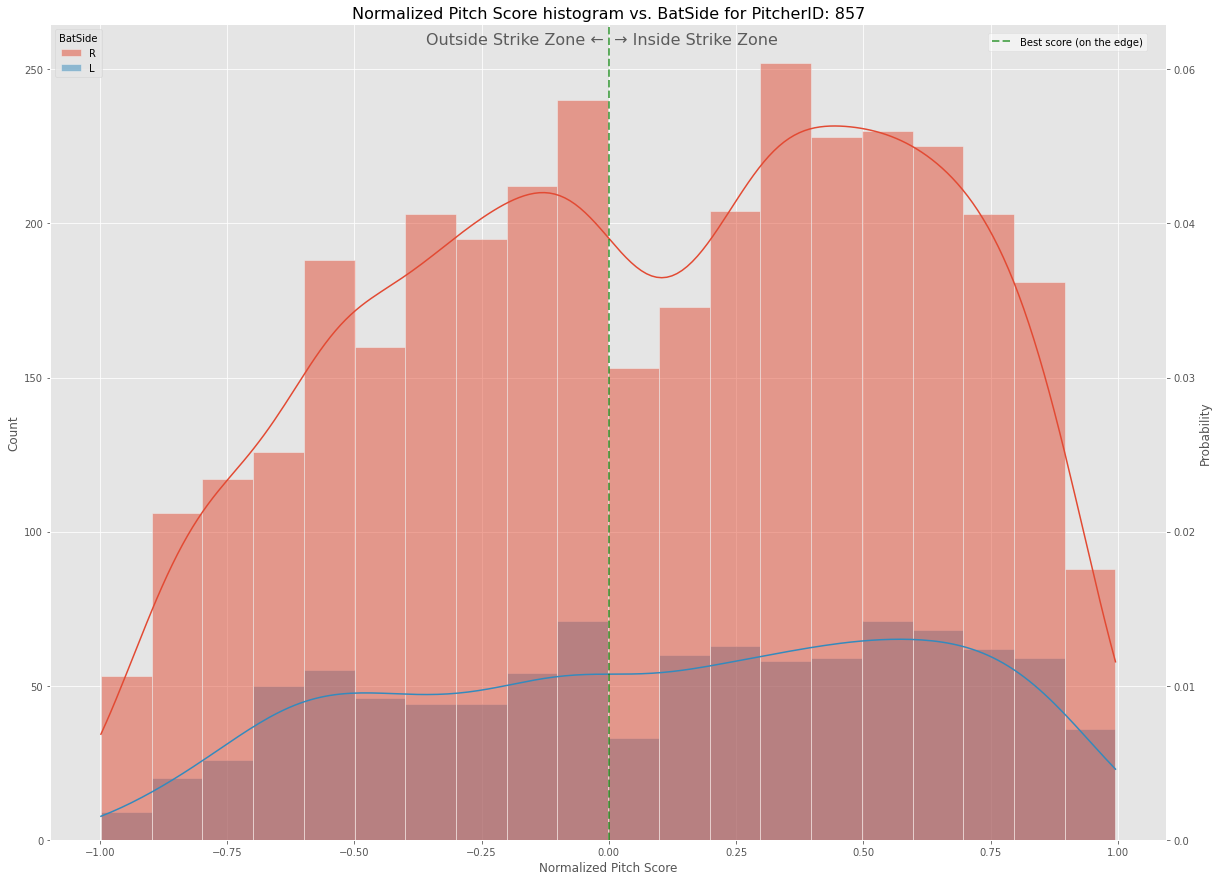

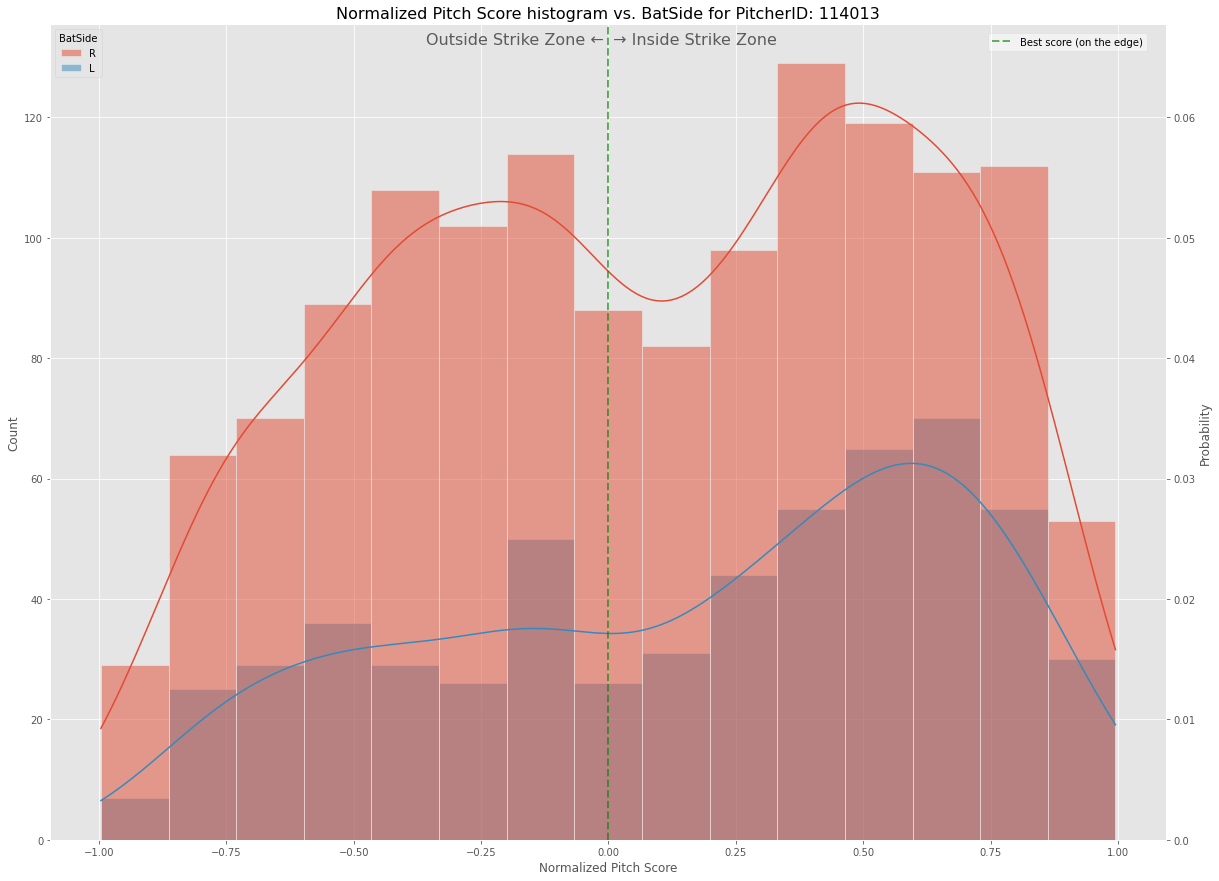

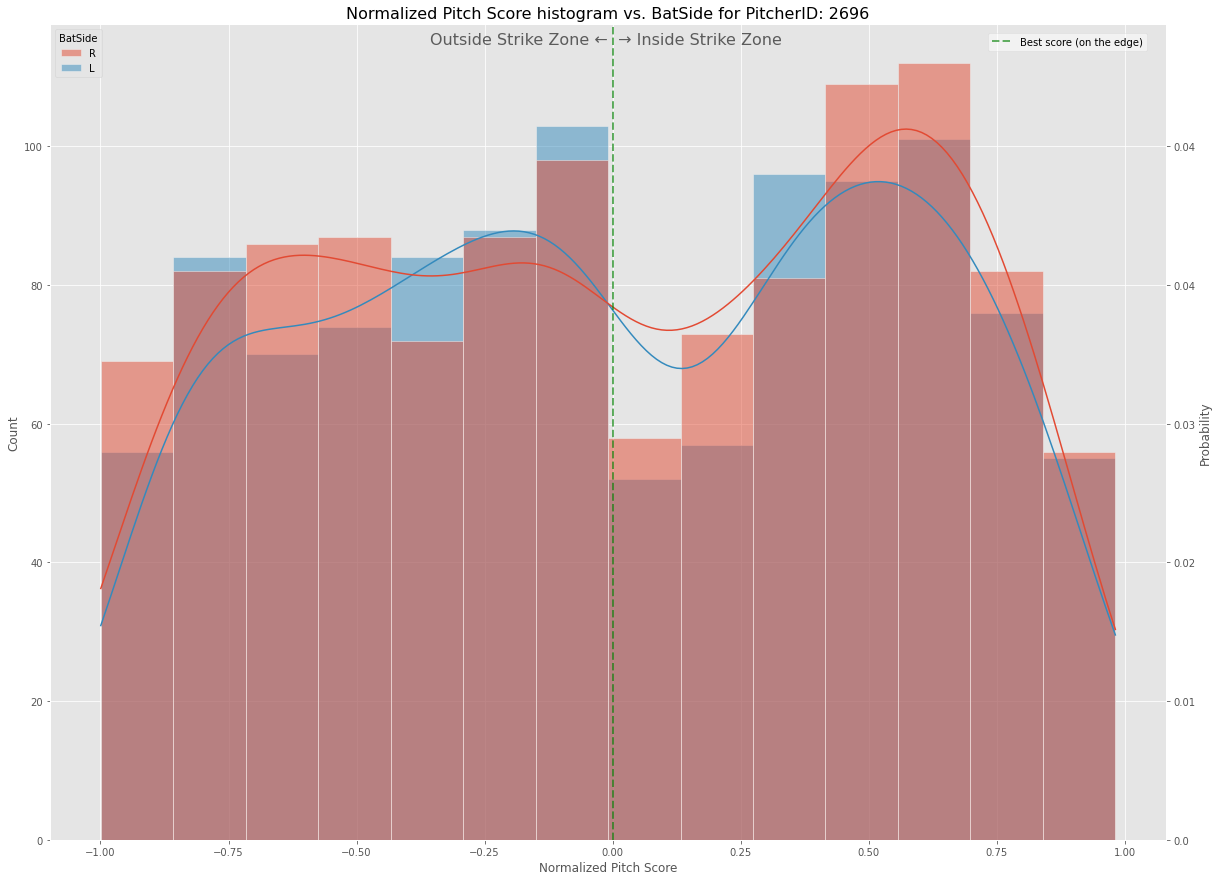

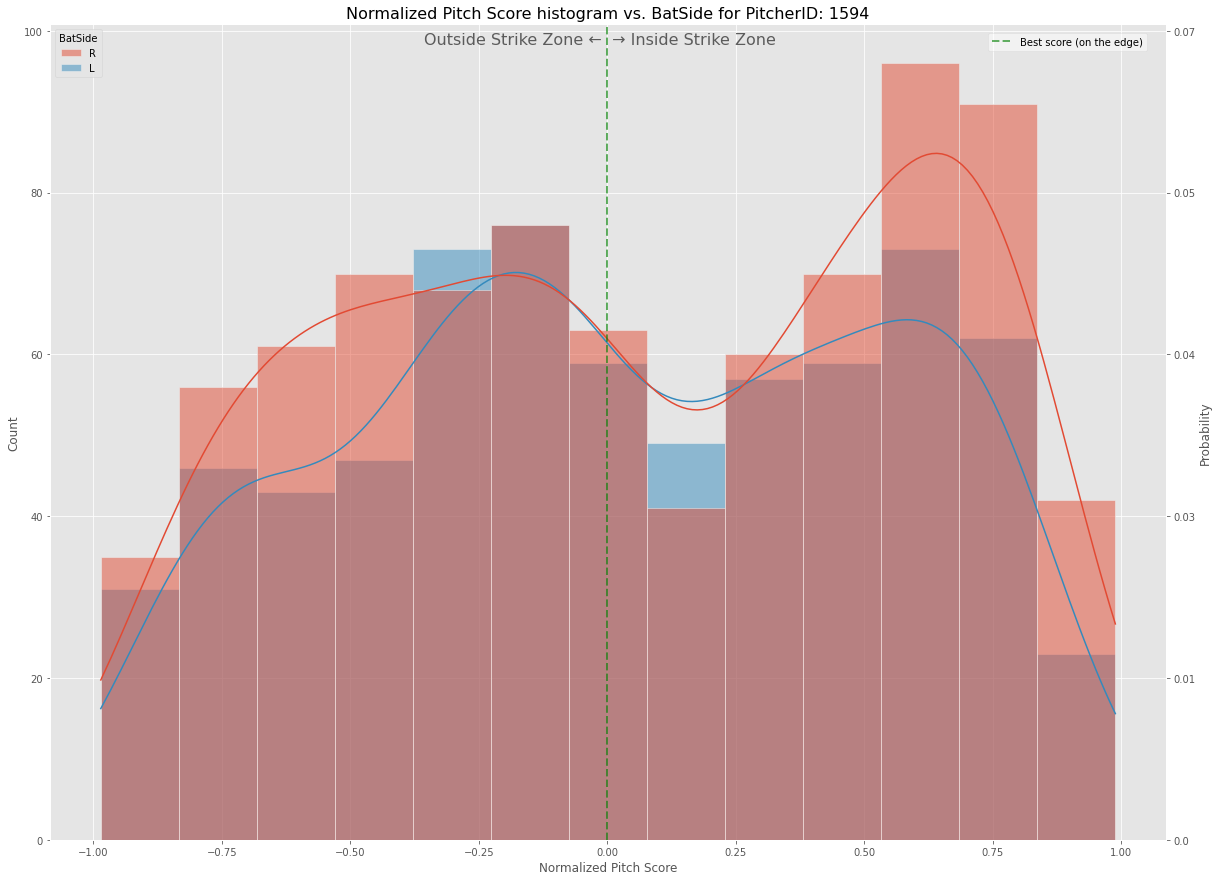

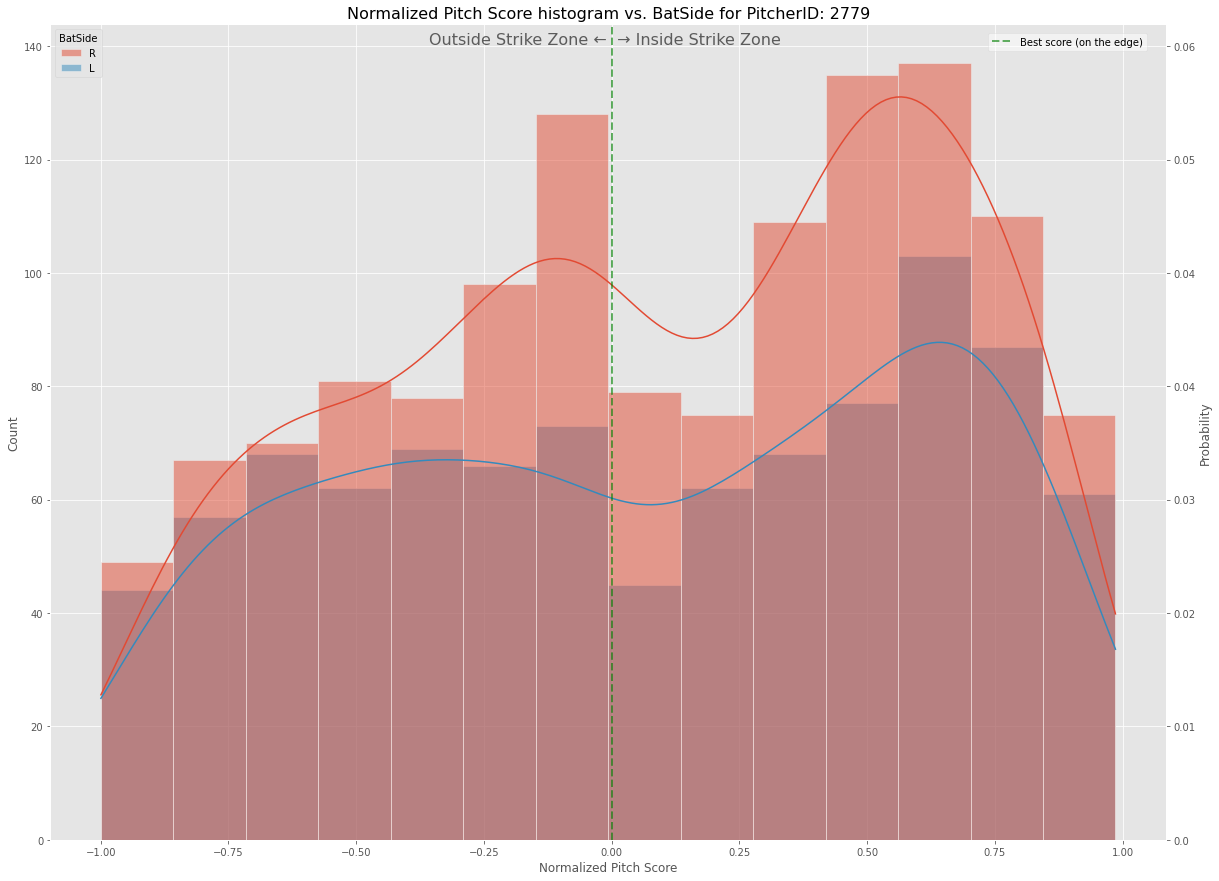

In [ ]:
var = "PitcherID"
col="BatSide"
for p in tqdm(df[var].unique()):
  plot_pitch_score_histogram(df[df[var]==p], col=col, title=f"Normalized Pitch Score histogram vs. {col} for {var}: {p}")

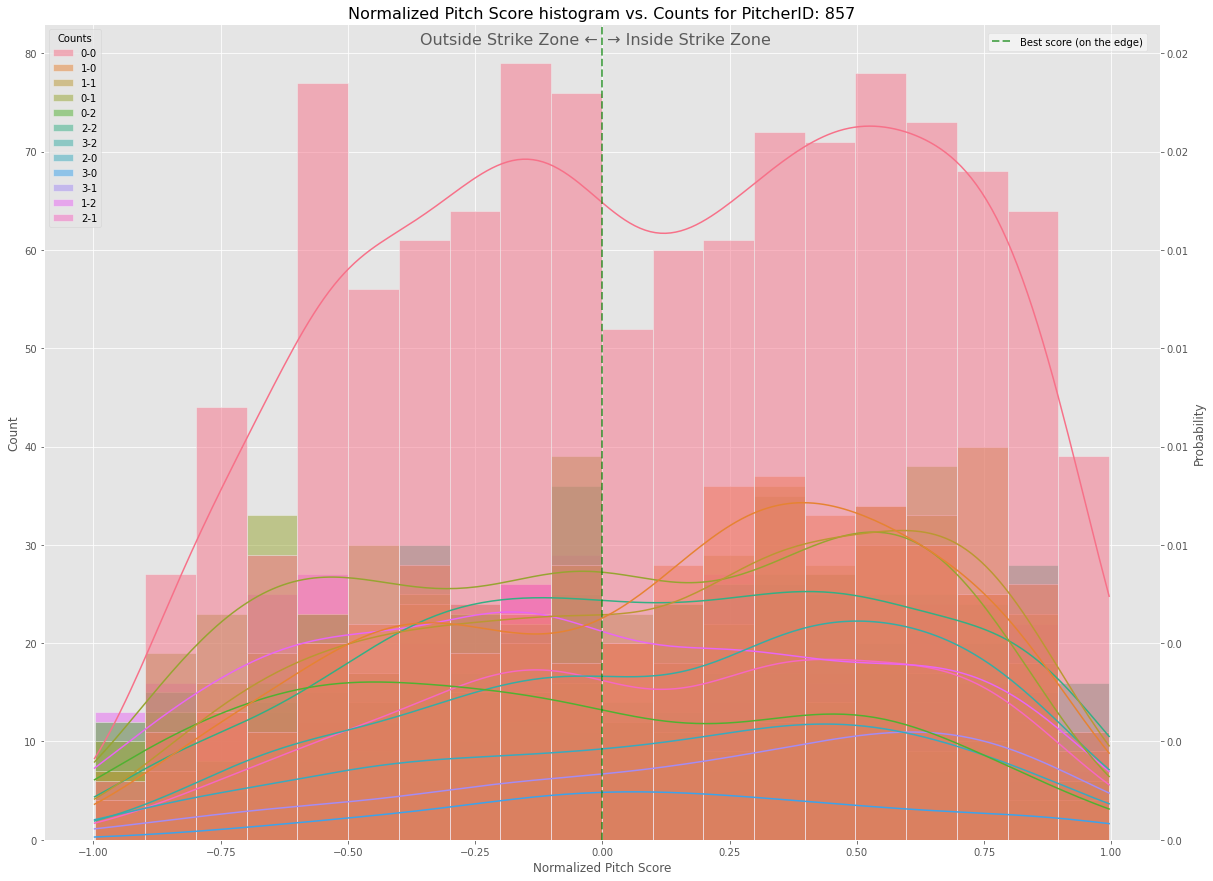

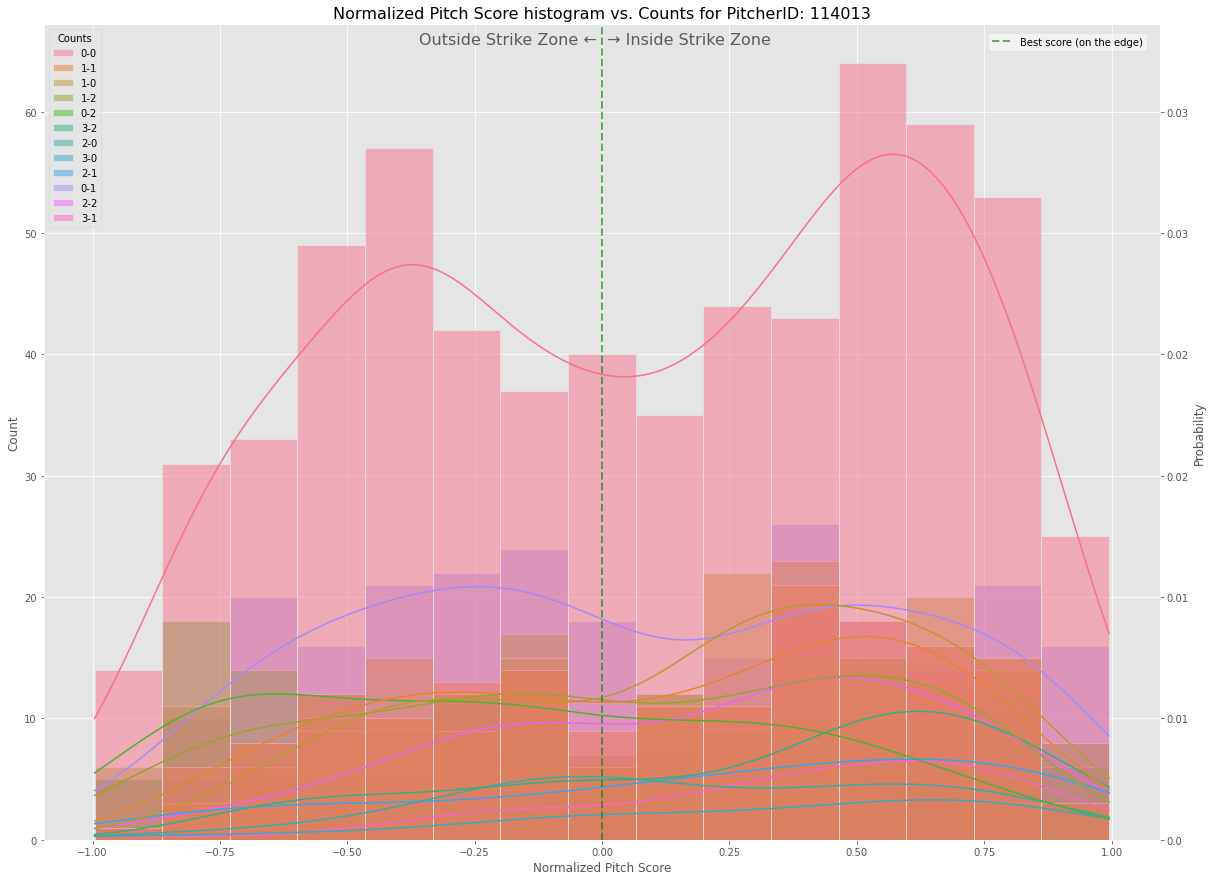

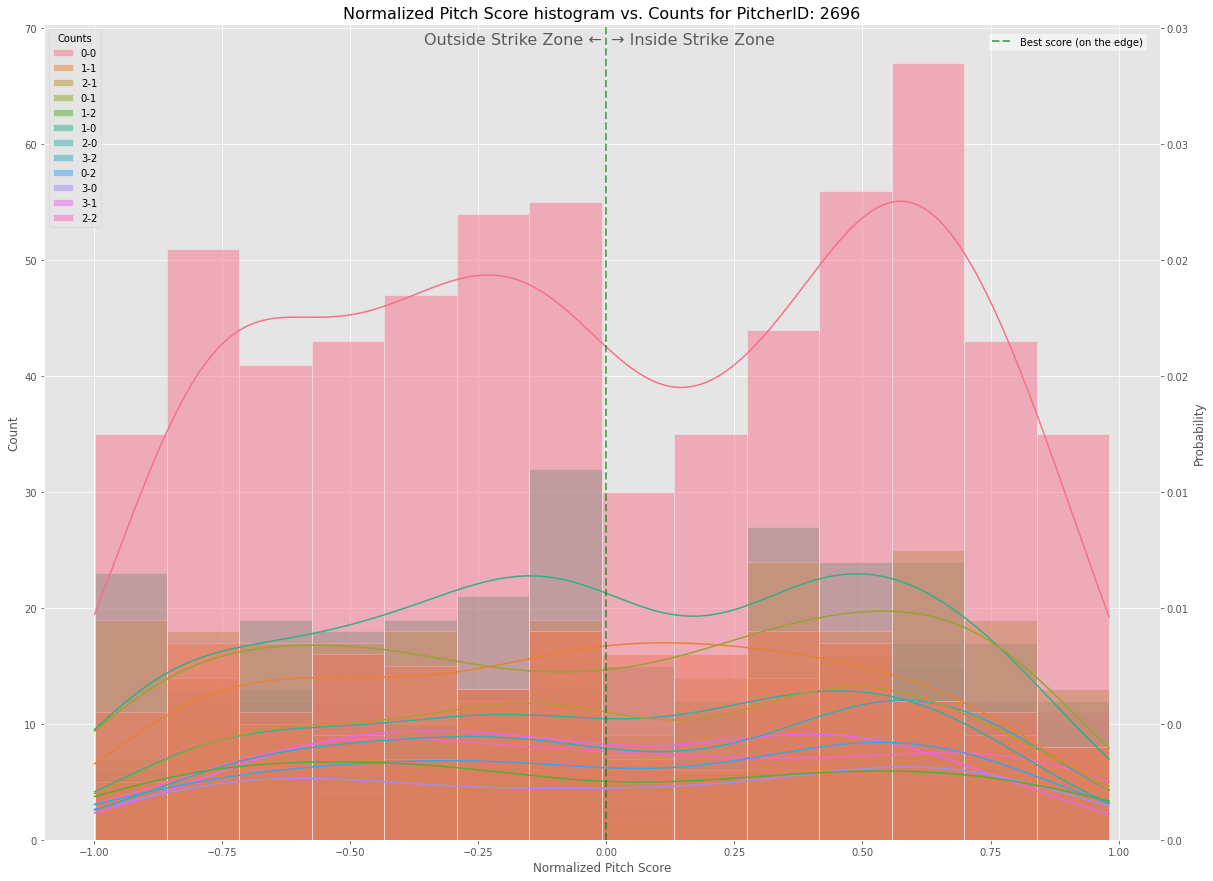

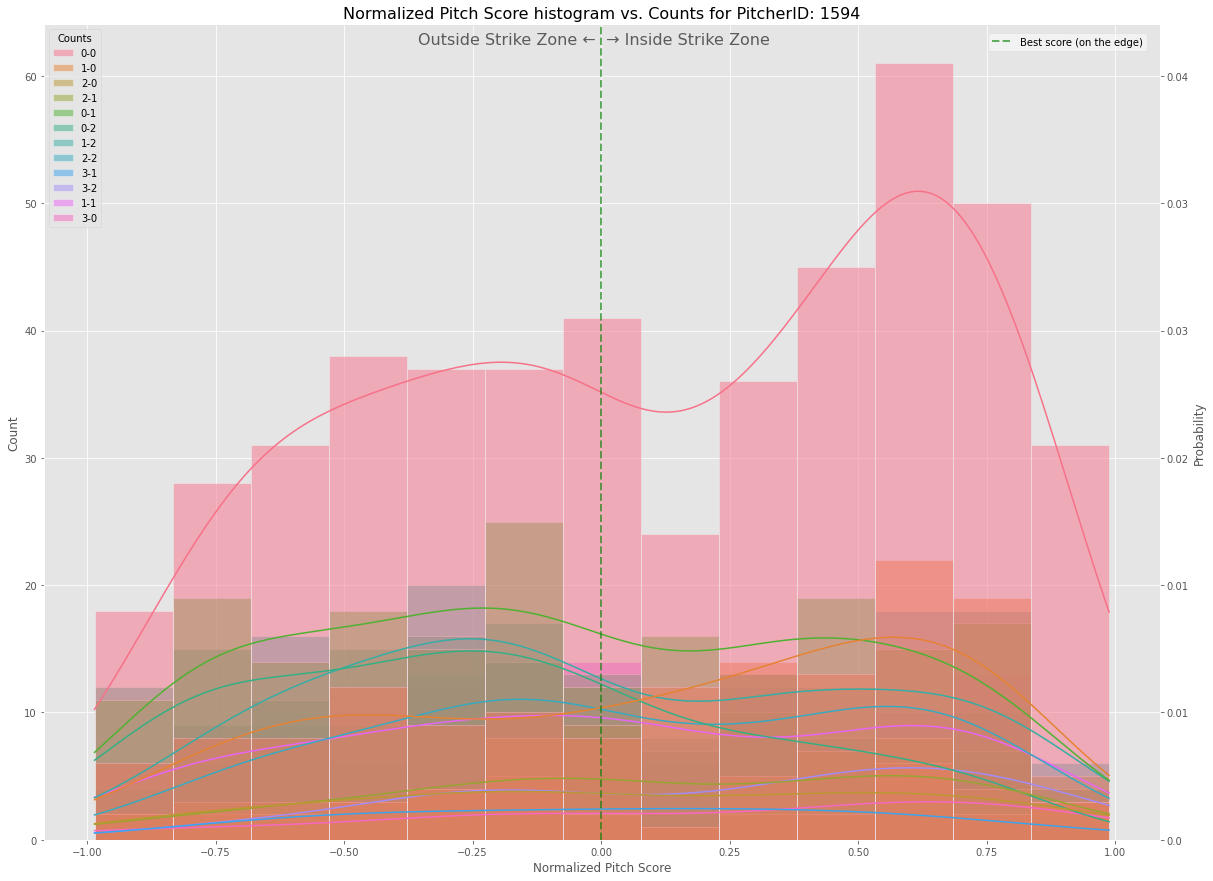

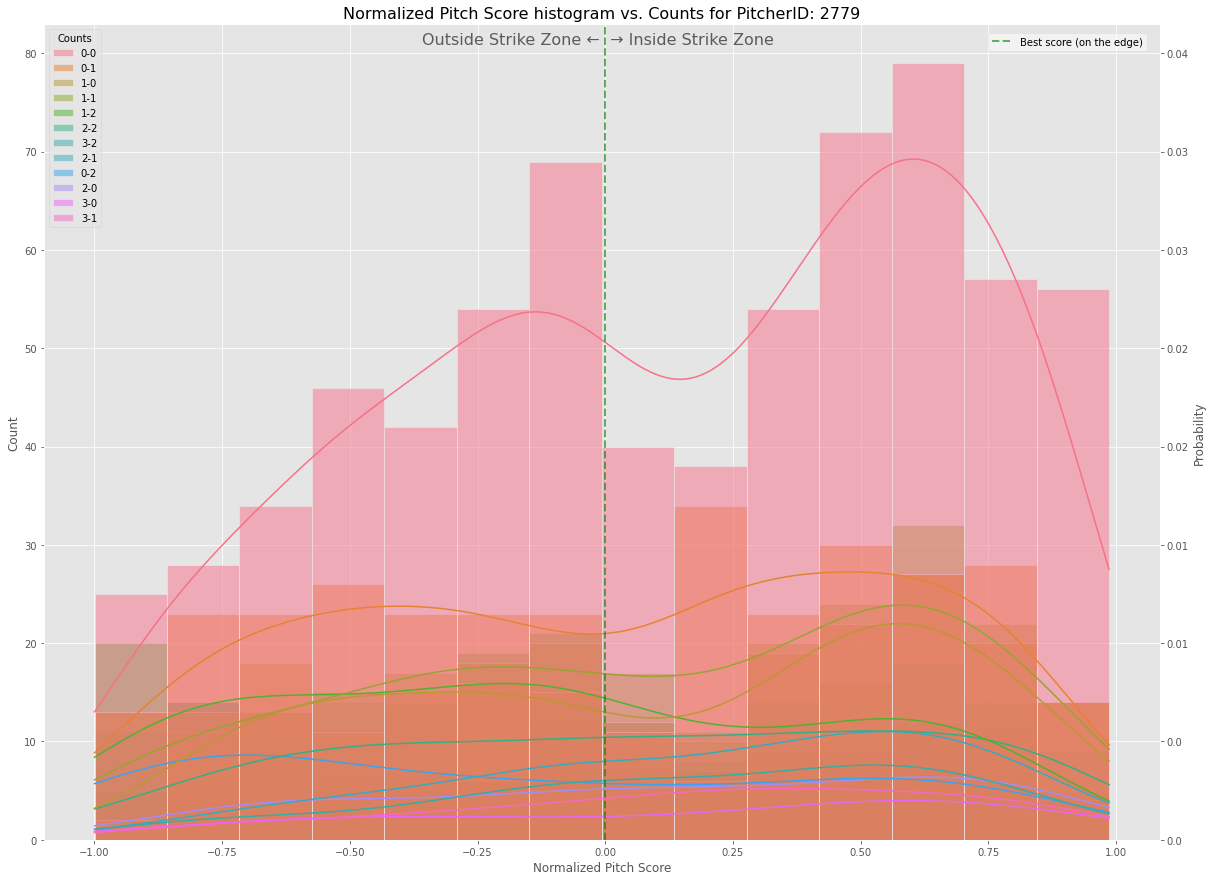

In [ ]:
var = "PitcherID"
col="Counts"
for p in tqdm(df[var].unique()):
  plot_pitch_score_histogram(df[df[var]==p], col=col, title=f"Normalized Pitch Score histogram vs. {col} for {var}: {p}")

In [ ]:
df.describe()

GamePitchSequence    PAofInning  ...   pitch_score  pitch_score_normalized
count       12481.000000  12481.000000  ...  12474.000000            12474.000000
mean          102.192453      2.649547  ...      0.250546                0.069450
std            70.691196      1.509402  ...      6.517820                0.531228
min             1.000000      1.000000  ...    -41.854893               -0.999537
25%            44.000000      1.000000  ...     -3.874986               -0.369202
50%            95.000000      2.000000  ...      0.957534                0.095692
75%           151.000000      3.000000  ...      5.487735                0.536952
max           480.000000     11.000000  ...     11.146867                0.995532

[8 rows x 14 columns]

## Custom Player Score

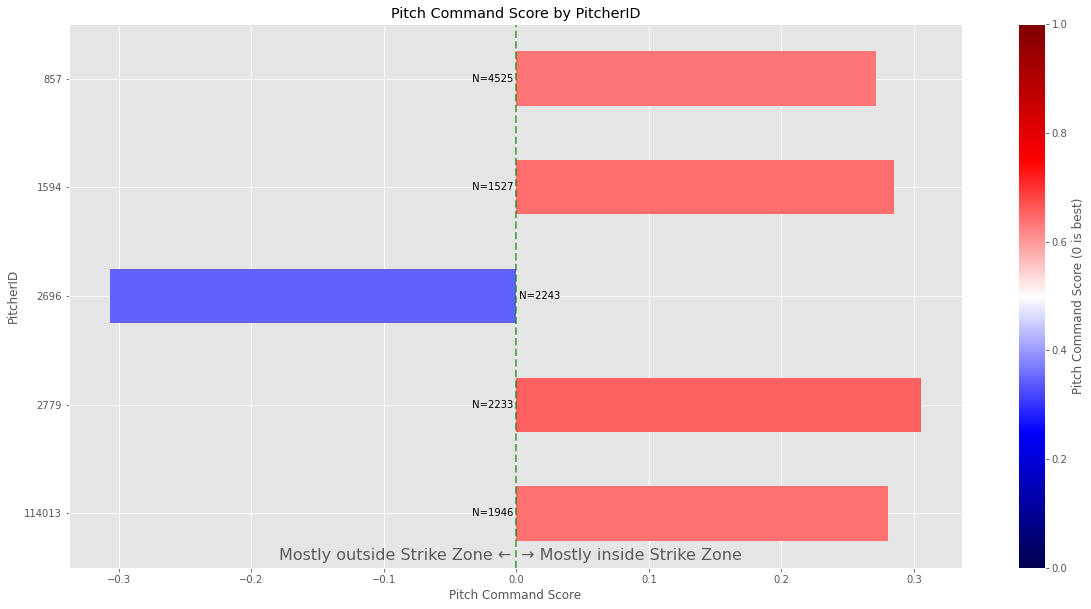

In [8]:
def player_score(pitch_score_normalized):
  sign = 1
  if pitch_score_normalized.median() < 0: #if most pitches are outside the strike zone, let the player score be negative
    sign=-1
  return sign*mse(pitch_score_normalized)

df_g = df[["PitcherID", "BatSide", "PitchType", "pitch_score_normalized"]].groupby(by=["PitcherID"]).agg([player_score, "count"])
display(df_g.style.background_gradient(cmap="seismic", vmin=-1, vmax=1, subset=[('pitch_score_normalized','player_score')]))
df_score = df_g.xs("player_score", axis=1, level=1)
df_count = df_g.xs("count", axis=1, level=1)
ax = df_score.plot(kind="barh", figsize=(20,10), title="Pitch Command Score by PitcherID", legend=False, color=(array_to_rgba(df_score.iloc[:,0], cmap=cm.seismic), None));
for i, (index, row) in enumerate(df_g.iterrows()):
  score = row.xs('player_score', level=1)[0]
  count = int(row.xs('count', level=1)[0])
  if score > 0: ax.text(0, i, f" N={count} ", color='black', horizontalalignment="right", verticalalignment="center")
  else: ax.text(0, i, f" N={count} ", color='black', horizontalalignment="left", verticalalignment="center")
ax.set_xlabel("Pitch Command Score");
ax.invert_yaxis()
ax.axvline(x=0, color='g', alpha=0.6, linestyle='--', lw=2, label="Best score (on the edge)")
ax.annotate(" → Mostly inside Strike Zone", xy=(0, ax.get_ybound()[1]*0.99), xytext=(0, ax.get_ybound()[1]*0.99), horizontalalignment="left", verticalalignment="bottom", size=16, alpha=0.6);
ax.annotate("Mostly outside Strike Zone ← ", xy=(0, ax.get_ybound()[1]*0.99), xytext=(0, ax.get_ybound()[1]*0.99), horizontalalignment="right", verticalalignment="bottom", size=16, alpha=0.6);
x = np.linspace(0, 1, 100)
N = 1000
cmap = plt.get_cmap('seismic',N)
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm);
cbar.ax.set_ylabel('Pitch Command Score (0 is best)');

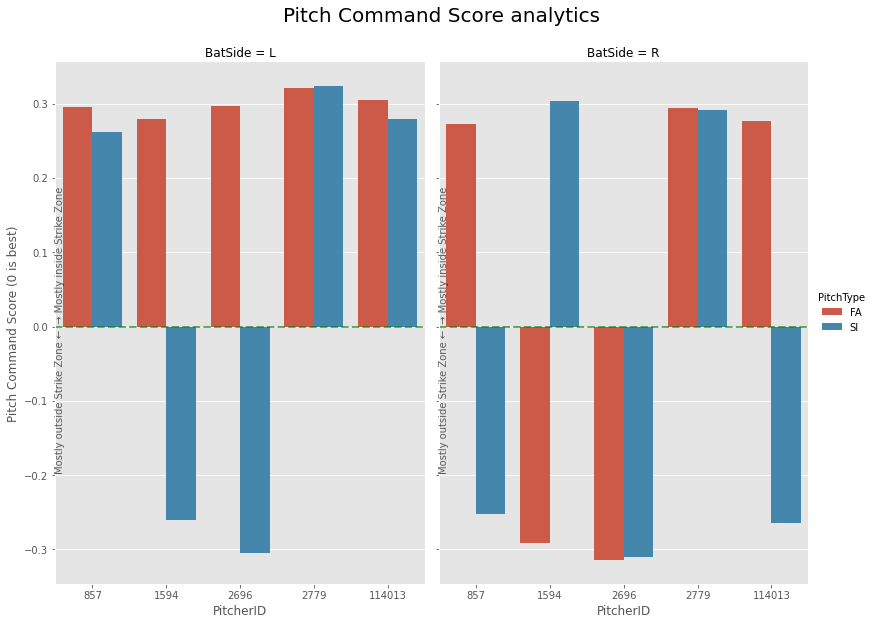

In [ ]:
df_g = pd.pivot_table(df, values="pitch_score_normalized", index="PitcherID", columns=["PitchType","BatSide"], aggfunc=[player_score, "count"])
display(df_g.style.background_gradient(cmap="seismic", vmin=-1, vmax=1, subset=[('player_score')]))
df_g = df_g.unstack().reset_index()
g = sns.catplot(data=df_g[df_g.level_0=="player_score"], x="PitcherID", y=0, hue="PitchType", col="BatSide", kind="bar", height=8, aspect=.7);
g.set_ylabels("Pitch Command Score (0 is best)");
g.fig.suptitle("Pitch Command Score analytics", fontsize=20, y=1.05);
for ax in g.axes[0]:
  ax.axhline(y=0, color='g', alpha=0.6, linestyle='--', lw=2, label="Best score (on the edge)");
  ax.annotate(" → Mostly inside Strike Zone", xy=(-0.5, 0), xytext=(-0.5, 0), horizontalalignment="left", verticalalignment="bottom", size=10, alpha=0.6, rotation=90);
  ax.annotate("Mostly outside Strike Zone ← ", xy=(-0.5, 0), xytext=(-0.5, 0), horizontalalignment="left", verticalalignment="top", size=10, alpha=0.6, rotation=90);

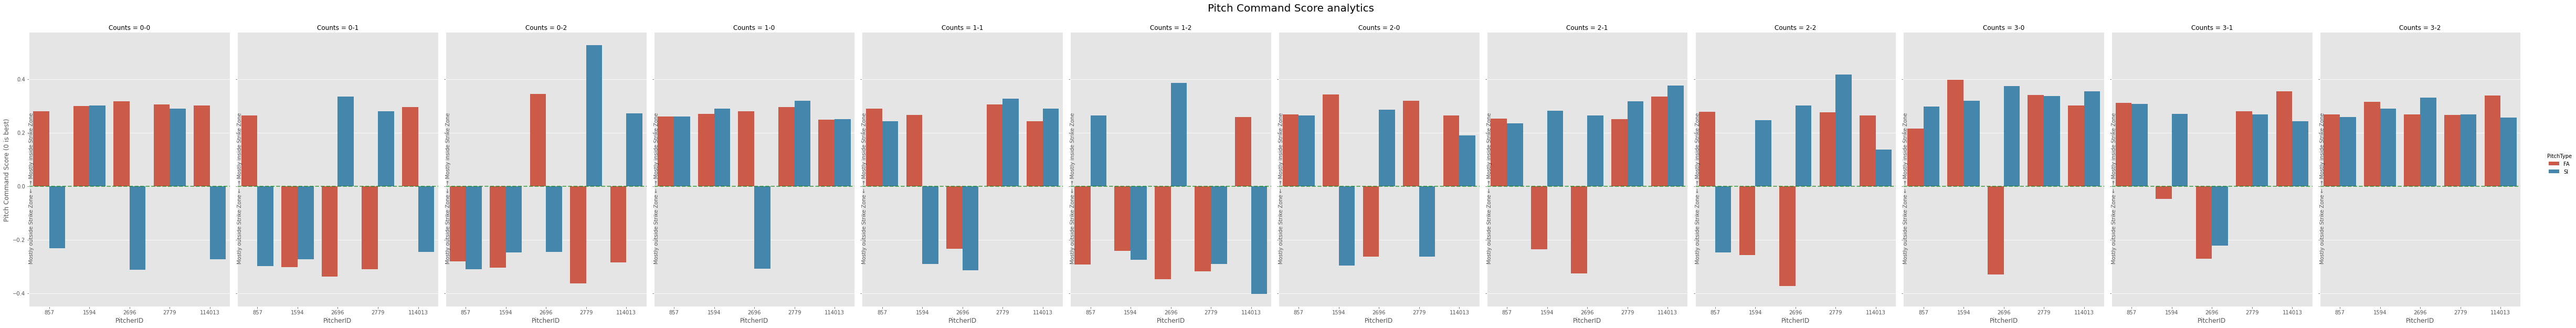

In [ ]:
df_g = pd.pivot_table(df, values="pitch_score_normalized", index="PitcherID", columns=["PitchType","Counts"], aggfunc=[player_score, "count"])
display(df_g.style.background_gradient(cmap="seismic", vmin=-1, vmax=1, subset=[('player_score')]))
df_g = df_g.unstack().reset_index()
g = sns.catplot(data=df_g[df_g.level_0=="player_score"], x="PitcherID", y=0, hue="PitchType", col="Counts", kind="bar", height=8, aspect=.7);
g.set_ylabels("Pitch Command Score (0 is best)");
g.fig.suptitle("Pitch Command Score analytics", fontsize=20, y=1.05);
for ax in g.axes[0]:
  ax.axhline(y=0, color='g', alpha=0.6, linestyle='--', lw=2, label="Best score (on the edge)");
  ax.annotate(" → Mostly inside Strike Zone", xy=(-0.5, 0), xytext=(-0.5, 0), horizontalalignment="left", verticalalignment="bottom", size=10, alpha=0.6, rotation=90);
  ax.annotate("Mostly outside Strike Zone ← ", xy=(-0.5, 0), xytext=(-0.5, 0), horizontalalignment="left", verticalalignment="top", size=10, alpha=0.6, rotation=90);

In [ ]:
df[(df.PitcherID==1594)&(df.PitchType=="FA")&(df.Counts=="3-1")]

YearID  ... pitch_score_normalized
3348    2019  ...              -0.091379
4636    2019  ...              -0.233439
6947    2019  ...               0.191640
10307   2019  ...              -0.297463

[4 rows x 21 columns]

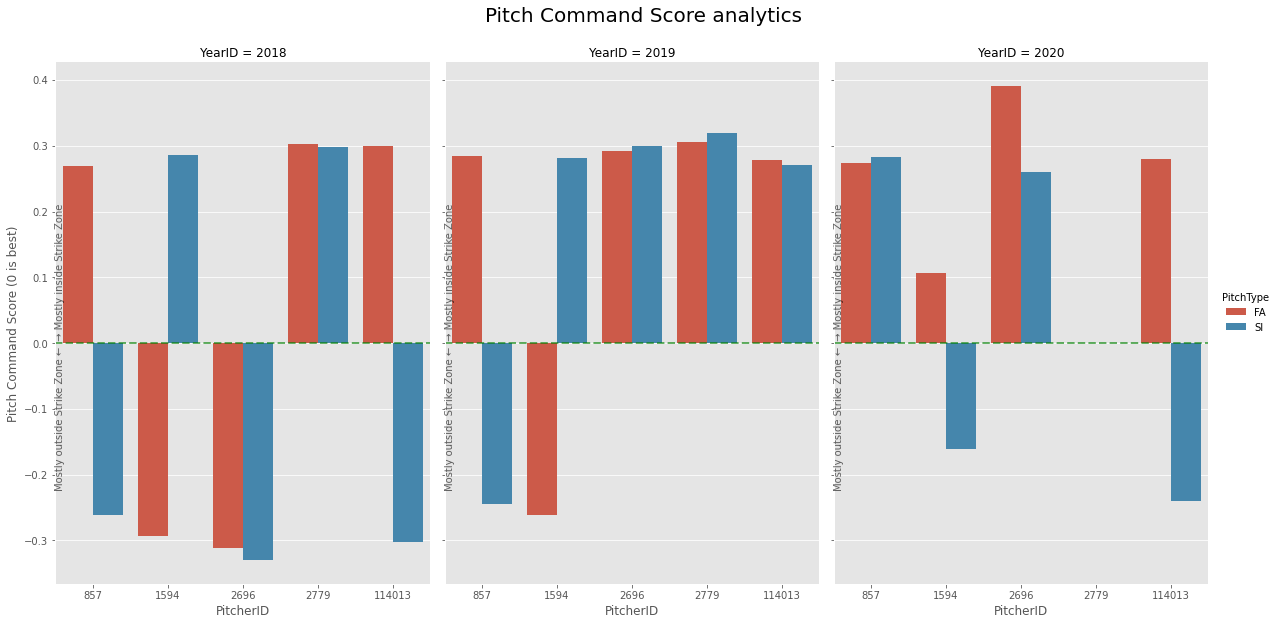

In [ ]:
df_g = pd.pivot_table(df, values="pitch_score_normalized", index="PitcherID", columns=["PitchType","YearID"], aggfunc=[player_score, "count"])
display(df_g.style.background_gradient(cmap="seismic", vmin=-1, vmax=1, subset=[('player_score')]))
df_g = df_g.unstack().reset_index()
g = sns.catplot(data=df_g[df_g.level_0=="player_score"], x="PitcherID", y=0, hue="PitchType", col="YearID", kind="bar", height=8, aspect=.7);
g.set_ylabels("Pitch Command Score (0 is best)");
g.fig.suptitle("Pitch Command Score analytics", fontsize=20, y=1.05);
for ax in g.axes[0]:
  ax.axhline(y=0, color='g', alpha=0.6, linestyle='--', lw=2, label="Best score (on the edge)");
  ax.annotate(" → Mostly inside Strike Zone", xy=(-0.5, 0), xytext=(-0.5, 0), horizontalalignment="left", verticalalignment="bottom", size=10, alpha=0.6, rotation=90);
  ax.annotate("Mostly outside Strike Zone ← ", xy=(-0.5, 0), xytext=(-0.5, 0), horizontalalignment="left", verticalalignment="top", size=10, alpha=0.6, rotation=90);

In [ ]:
var = "PitcherID"
col = "YearID"
for p in tqdm(df[var].unique()):
  plot_pitch_location(df[df[var]==p], col=col, title=f"Pitch location estimation vs. {col} for {var}: {p}")

Output hidden; open in https://colab.research.google.com to view.

# Conclusion:

Overall, pitcher 857 seems to have the best fastball pitch command, since his score is closest to 0, meaning he had more pitches near the strike zone edge. 

One interesting observation: 

If we only look at year 2020, pitcher 1594 seems to have the best pitch command score. This is because he had only very few pitches that year and most of the pitches ended up close to the strike zone edge. So the pitch command score is indeed able to reflect how good the pitcher is at putting the ball close to the strike zone edge.

Limitations:

1. The analysis assumes that the pitcher wants to aim at the edge of the strike zone.

2. The analysis assumes that the strike zone is a universal box shape.

3. The Command Pitch score is calculated purely based on the pitch location.

# Additional thoughts:

1. PCA could be used to measure the anisotropy of the pitch location scatter. The more elongated the pitch scatter is (in a diagonal direction), the less control/command the pitcher has.

2. Data are needed for the batter's response to each pitch (was it a ball or a strike). If such data are available, we could model the actual strike zone better.